<a href="https://colab.research.google.com/github/oluwafemidiakhoa/MLprject/blob/main/ArtificialReseacher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import uuid
from openai import OpenAI
from kaggle.api.kaggle_api_extended import KaggleApi
from google.colab import userdata

# Set environment variables for OpenAI and Kaggle credentials
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

# Initialize OpenAI client
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

# Base Agent Class
class Agent:
    def __init__(self, name, role):
        self.agent_id = str(uuid.uuid4())
        self.name = name
        self.role = role
        self.memory = []
        self.api_client = client
        self.kaggle_api = KaggleApi()
        self.kaggle_api.authenticate()  # Authenticate Kaggle API

    def query_openai(self, prompt):
        response = self.api_client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}]
        )
        return response.choices[0].message.content

    def retrieve_kaggle_data(self, dataset, file_name):
        try:
            self.kaggle_api.dataset_download_file(dataset, file_name)
            return f"Downloaded {file_name} from {dataset} on Kaggle."
        except Exception as e:
            return f"Failed to download Kaggle dataset: {e}"

# Specialized Agents

# PlanningAgent
class PlanningAgent(Agent):
    def create_plan(self, goal):
        prompt = f"Create a comprehensive research and development plan for the goal: {goal}"
        plan = self.query_openai(prompt)
        self.memory.append({"task": "research_plan", "data": plan})
        return plan

# LiteratureReviewAgent
class LiteratureReviewAgent(Agent):
    def conduct_literature_review(self, topic, kaggle_dataset=None, file_name=None):
        prompt = f"Provide a literature review on {topic}."
        review = self.query_openai(prompt)
        if kaggle_dataset and file_name:
            kaggle_data_info = self.retrieve_kaggle_data(kaggle_dataset, file_name)
            review += f"\n\n{str(kaggle_data_info)}"
        self.memory.append({"task": "literature_review", "data": review})
        return review

# HypothesisAgent
class HypothesisAgent(Agent):
    def generate_hypotheses(self, literature_review):
        prompt = f"Based on the literature review, generate hypotheses."
        hypotheses = self.query_openai(prompt)
        self.memory.append({"task": "hypotheses", "data": hypotheses})
        return hypotheses

# ExperimentationAgent
class ExperimentationAgent(Agent):
    def design_experiments(self, hypotheses):
        prompt = f"Design experiments to test the following hypotheses: {hypotheses}"
        experiments = self.query_openai(prompt)
        self.memory.append({"task": "experiments", "data": experiments})
        return experiments

# CodeSynthesisAgent
class CodeSynthesisAgent(Agent):
    def generate_code(self, experiment_design):
        prompt = f"Generate modular, well-documented Python code for the experiment design: {experiment_design}"
        code = self.query_openai(prompt)
        self.memory.append({"task": "code_synthesis", "data": code})
        return code

# DataAnalysisAgent
import pandas as pd
import matplotlib.pyplot as plt

class DataAnalysisAgent(Agent):
    def analyze_data(self, data_description, kaggle_dataset=None, file_name=None):
        prompt = f"Analyze data with the description: {data_description}"
        analysis = self.query_openai(prompt)

        # Download dataset if needed
        if kaggle_dataset and file_name:
            self.retrieve_kaggle_data(kaggle_dataset, file_name)

        # Load the dataset
        data_path = f"./{file_name}"  # Adjust path if needed
        try:
            df = pd.read_csv(data_path)

            # Process the data for visualization
            self.visualize_temperature_trends(df)
            self.memory.append({"task": "data_analysis", "data": analysis})

            return f"Data analysis completed with visualizations. {analysis}"
        except Exception as e:
            return f"Failed to analyze data: {e}"

    def visualize_temperature_trends(self, df):
        # Ensure the dataset has the required columns
        if 'dt' in df.columns and 'AverageTemperature' in df.columns:
            # Convert date column to datetime format
            df['dt'] = pd.to_datetime(df['dt'])

            # Resample data to get yearly averages
            df_yearly = df.set_index('dt').resample('Y').mean()

            # Plot temperature trends
            plt.figure(figsize=(12, 6))
            plt.plot(df_yearly.index, df_yearly['AverageTemperature'], label='Average Temperature')
            plt.title("Global Average Temperature Over Time")
            plt.xlabel("Year")
            plt.ylabel("Temperature (°C)")
            plt.legend()
            plt.show()
        else:
            print("Required columns not found in dataset for visualization.")

# ValidationAgent
class ValidationAgent(Agent):
    def validate_results(self, analysis):
        prompt = f"Validate the data analysis for accuracy and reliability: {analysis}"
        validation = self.query_openai(prompt)
        self.memory.append({"task": "validation", "data": validation})
        return validation

# DocumentationAgent
class DocumentationAgent(Agent):
    def create_documentation(self, inputs):
        prompt = f"Create a comprehensive research report based on the following: {inputs}"
        documentation = self.query_openai(prompt)
        self.memory.append({"task": "documentation", "data": documentation})
        return documentation

# SoftwareEngineeringAgent
class SoftwareEngineeringAgent(Agent):
    def create_architecture(self, goal):
        prompt = f"Design a software architecture for achieving the goal: {goal}"
        architecture = self.query_openai(prompt)
        self.memory.append({"task": "architecture_design", "data": architecture})
        return architecture

    def implement_testing_framework(self, code):
        prompt = f"Create a testing framework for the following code: {code}"
        tests = self.query_openai(prompt)
        self.memory.append({"task": "testing_framework", "data": tests})
        return tests

# Execute Research Workflow
def execute_research_workflow(goal, kaggle_dataset=None, file_name=None):
    planning_agent = PlanningAgent("Planning Agent", "Creates detailed research plans.")
    literature_agent = LiteratureReviewAgent("Literature Review Agent", "Conducts literature reviews.")
    hypothesis_agent = HypothesisAgent("Hypothesis Generation Agent", "Generates research hypotheses.")
    experimentation_agent = ExperimentationAgent("Experimentation Agent", "Designs experiments.")
    code_agent = CodeSynthesisAgent("Code Synthesis Agent", "Generates code.")
    data_agent = DataAnalysisAgent("Data Analysis Agent", "Analyzes data.")
    validation_agent = ValidationAgent("Validation Agent", "Validates results.")
    documentation_agent = DocumentationAgent("Documentation Agent", "Creates documentation.")
    software_engineer = SoftwareEngineeringAgent("Software Engineering Agent", "Creates software architecture and testing frameworks.")

    # Step-by-step execution
    plan = planning_agent.create_plan(goal)
    review = literature_agent.conduct_literature_review(goal, kaggle_dataset, file_name)
    hypotheses = hypothesis_agent.generate_hypotheses(review)
    experiments = experimentation_agent.design_experiments(hypotheses)
    code = code_agent.generate_code(experiments)
    analysis = data_agent.analyze_data("Experiment data analysis", kaggle_dataset, file_name)
    validation = validation_agent.validate_results(analysis)

    # Software Engineering Steps
    architecture = software_engineer.create_architecture(goal)
    testing_framework = software_engineer.implement_testing_framework(code)

    # Compile documentation
    inputs = f"{plan}\n\n{review}\n\n{hypotheses}\n\n{experiments}\n\n{code}\n\n{analysis}\n\n{validation}\n\n{architecture}\n\n{testing_framework}"
    final_report = documentation_agent.create_documentation(inputs)

    print("\n=== Final Research Report ===\n")
    print(final_report)

# Execute the workflow with a goal and Kaggle dataset
goal = "Develop a machine learning model for climate data analysis."
kaggle_dataset = "berkeleyearth/climate-change-earth-surface-temperature-data"
file_name = "GlobalLandTemperaturesByCity.csv"

# Execute the research workflow
execute_research_workflow(goal, kaggle_dataset, file_name)


In [ ]:
# Test downloading the new dataset directly
!kaggle datasets download -d berkeleyearth/climate-change-earth-surface-temperature-data --unzip


Dataset URL: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data
License(s): CC-BY-NC-SA-4.0
 96% 81.0M/84.7M [00:00<00:00, 173MB/s]
100% 84.7M/84.7M [00:00<00:00, 140MB/s]


In [ ]:
# Define the research goal with the climate dataset
goal = "Analyze historical global temperature data and identify trends related to climate change."

# Execute the workflow
execute_research_workflow(goal, kaggle_dataset="berkeleyearth/climate-change-earth-surface-temperature-data", file_name="GlobalLandTemperaturesByCity.csv")


Dataset URL: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data
Dataset URL: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data


<ipython-input-319-cd1f7912aafc>:118: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df.set_index('dt').resample('Y').mean()



=== Final Research Report ===

XVI. Conclusions

The analysis of historical global temperature data varies in the conclusion due to different factors considered, methodologies used, and the perspective of researchers. However, the similarities across most of these studies include the identification of a clear warming trend occurring throughout the planet. While some studies take in factors such as natural climate variability, alternate data sources, and the impact of human factors on this heating trend, there is a clear consensus between scientists on a few fronts. 

1. The Climate is Undeniably Warming
Most, if not all, studies agree that the earth is getting warmer. The exact degree to which the earth has warmed can vary between studies, though most estimates put it at around one degree Celsius since 1880. The acceleration of the warming trend throughout the twentieth century also seems to imply that this warming won't stop soon.

2. Human Activities are a Significant Factor
Human a

In [ ]:
# Define the research goal
goal = "Analyze historical global temperature data and identify trends related to climate change."

# Execute the workflow
execute_research_workflow(goal, kaggle_dataset="berkeleyearth/climate-change-earth-surface-temperature-data", file_name="GlobalLandTemperaturesByCity.csv")


Dataset URL: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data
Dataset URL: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data


<ipython-input-319-cd1f7912aafc>:118: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df.set_index('dt').resample('Y').mean()



=== Final Research Report ===

X. Challenges & Limitations

Several challenges and limitations may emerge during the research process, some of them include:

1. **Data Quality and Completeness**: Reliable conclusions depend on the quality and completeness of the data. Issues like missing data, inconsistent measurements, or bias in data collection can affect the outcomes.

2. **Complexity of Climate Change**: Climate change is an extensively complex phenomenon that takes into account numerous variables such as greenhouse gas emissions, deforestation, and technology advancements, among others, making it challenging to identify definite causing factors.

3. **Data Processing and Analysis**: Large volumes of data require robust data processing and analysis capabilities. There may be limitations in terms of computational resources or suitable analytical methodologies.

4. **Predictive Model Limitations**: Regardless of the sophistication of the model, predictions will always contain some l

In [ ]:
import os
import uuid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from openai import OpenAI
from kaggle.api.kaggle_api_extended import KaggleApi

# Set up environment and API clients
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

import time

class Agent:
    def __init__(self, name, role):
        self.agent_id = str(uuid.uuid4())
        self.name = name
        self.role = role
        self.memory = []
        self.api_client = client
        self.kaggle_api = KaggleApi()
        self.kaggle_api.authenticate()

    def query_openai(self, prompt, retries=5, initial_delay=2):
        """Query OpenAI API with exponential backoff on rate limits."""
        for attempt in range(retries):
            try:
                response = self.api_client.chat.completions.create(
                    model="gpt-4",
                    messages=[{"role": "user", "content": prompt}]
                )
                return response.choices[0].message.content
            except openai.error.RateLimitError as e:
                if attempt < retries - 1:
                    delay = initial_delay * (2 ** attempt)  # Exponential backoff
                    print(f"Rate limit exceeded. Retrying in {delay} seconds...")
                    time.sleep(delay)
                else:
                    print("Maximum retries reached. Check your API quota.")
                    raise e


    def query_openai(self, prompt):
        response = self.api_client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}]
        )
        return response.choices[0].message.content

    def retrieve_kaggle_data(self, dataset, file_name):
        try:
            self.kaggle_api.dataset_download_file(dataset, file_name)
            return f"Downloaded {file_name} from {dataset} on Kaggle."
        except Exception as e:
            return f"Failed to download Kaggle dataset: {e}"

# 1. Generative Science Agent - Creates novel hypotheses based on literature
class GenerativeScienceAgent(Agent):
    def create_innovative_hypotheses(self, topic):
        prompt = f"Generate groundbreaking, novel hypotheses and questions for the topic '{topic}'. Identify research gaps."
        hypotheses = self.query_openai(prompt)
        self.memory.append({"task": "innovative_hypotheses", "data": hypotheses})
        return hypotheses

# 2. Adaptive Experimentation Agent - Continuously improves experiments with reinforcement learning
class AdaptiveExperimentationAgent(Agent):
    def design_and_optimize_experiments(self, hypotheses):
        prompt = f"Design experiments to test the following hypotheses, with reinforcement learning for continuous improvement: {hypotheses}"
        experiment_design = self.query_openai(prompt)
        self.memory.append({"task": "adaptive_experiment_design", "data": experiment_design})
        return experiment_design

# 3. Simulated Validation Agent - Runs simulations for hypothesis validation
class SimulatedValidationAgent(Agent):
    def validate_with_simulation(self, experiment_design):
        prompt = f"Run simulations based on the following experiment design: {experiment_design}. Predict outcomes and validate hypotheses."
        simulation_results = self.query_openai(prompt)
        self.memory.append({"task": "simulated_validation", "data": simulation_results})
        return simulation_results

# 4. Autonomous Data Analysis Agent - Analyzes data, optimizes analysis methods
class AutonomousDataAnalysisAgent(Agent):
    def analyze_and_learn(self, data):
        analysis_summary = f"Perform advanced data analysis, including pattern detection and trend identification in data."
        self.memory.append({"task": "data_analysis", "data": analysis_summary})
        return analysis_summary

    def visualize_data_trends(self, df):
        df['dt'] = pd.to_datetime(df['dt'])
        df_yearly = df.set_index('dt').resample('Y').mean()

        plt.figure(figsize=(10, 6))
        plt.plot(df_yearly.index, df_yearly['AverageTemperature'], label="Yearly Average Temperature")
        plt.xlabel("Year")
        plt.ylabel("Temperature (°C)")
        plt.title("Temperature Trend Over Years")
        plt.legend()
        plt.show()

# 5. Knowledge Fusion and Optimization Agent - Learns from all agents and optimizes knowledge
class KnowledgeFusionAgent(Agent):
    def integrate_knowledge(self, results):
        prompt = f"Integrate findings from all agents to optimize knowledge and suggest next steps."
        integrated_knowledge = self.query_openai(prompt)
        self.memory.append({"task": "knowledge_integration", "data": integrated_knowledge})
        return integrated_knowledge

# 6. Advanced Documentation and Publication Agent - Produces a final research report
class DocumentationAgent(Agent):
    def compile_paper(self, sections):
        prompt = f"Compile a structured, publishable research report with sections: {sections}"
        paper = self.query_openai(prompt)
        self.memory.append({"task": "documentation", "data": paper})
        return paper

# Research Workflow Orchestrator - Manages and coordinates all agents
class ProjectManagerAgent(Agent):
    def execute_advanced_research(self, goal, kaggle_dataset=None, file_name=None):
        # Initialize all agents
        gen_agent = GenerativeScienceAgent("Generative Science Agent", "Creates innovative hypotheses")
        exp_agent = AdaptiveExperimentationAgent("Experimentation Agent", "Designs optimized experiments")
        sim_agent = SimulatedValidationAgent("Simulation Agent", "Validates hypotheses with simulations")
        data_agent = AutonomousDataAnalysisAgent("Data Analysis Agent", "Performs autonomous data analysis")
        fusion_agent = KnowledgeFusionAgent("Fusion Agent", "Fuses knowledge across all agents")
        doc_agent = DocumentationAgent("Documentation Agent", "Compiles publishable report")

        # 1. Generative Science and Hypothesis Creation
        hypotheses = gen_agent.create_innovative_hypotheses(goal)

        # 2. Experiment Design and Optimization
        experiments = exp_agent.design_and_optimize_experiments(hypotheses)

        # 3. Simulated Validation of Hypotheses
        simulation_results = sim_agent.validate_with_simulation(experiments)

        # 4. Retrieve Data and Conduct Analysis
        data = data_agent.retrieve_kaggle_data(kaggle_dataset, file_name)
        data_analysis = data_agent.analyze_and_learn(data)
        data_agent.visualize_data_trends(pd.read_csv(file_name))

        # 5. Integrate and Optimize Knowledge
        integrated_knowledge = fusion_agent.integrate_knowledge({
            "hypotheses": hypotheses,
            "experiments": experiments,
            "simulation": simulation_results,
            "data_analysis": data_analysis
        })

        # 6. Documentation and Report Generation
        sections = {
            "Goal": goal,
            "Hypotheses": hypotheses,
            "Experiment Design": experiments,
            "Simulation Results": simulation_results,
            "Data Analysis": data_analysis,
            "Integrated Knowledge": integrated_knowledge
        }
        final_paper = doc_agent.compile_paper(sections)

        print("\n=== Final Research Report ===\n")
        print(final_paper)

# Execute the workflow
goal = "Investigate the impact of climate change on global temperature trends using historical data."
kaggle_dataset = "berkeleyearth/climate-change-earth-surface-temperature-data"
file_name = "GlobalLandTemperaturesByCity.csv"

manager = ProjectManagerAgent("Project Manager", "Orchestrates advanced research workflow")
manager.execute_advanced_research(goal, kaggle_dataset, file_name)


AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-prosk****************************************************************************************************************************************************************************************************************************************************************************************************************************fyIA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}

In [ ]:
import os
import uuid
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from openai import OpenAI, RateLimitError
from kaggle.api.kaggle_api_extended import KaggleApi

# Set up environment variables and API clients
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

# Base Agent Class with API and rate-limiting handling
class Agent:
    def __init__(self, name, role):
        self.agent_id = str(uuid.uuid4())
        self.name = name
        self.role = role
        self.memory = []
        self.api_client = client
        self.kaggle_api = KaggleApi()
        self.kaggle_api.authenticate()

    def query_openai(self, prompt, retries=5, initial_delay=2):
        """Query OpenAI API with exponential backoff on rate limits."""
        for attempt in range(retries):
            try:
                response = self.api_client.chat.completions.create(
                    model="gpt-4",
                    messages=[{"role": "user", "content": prompt}]
                )
                return response.choices[0].message.content
            except RateLimitError as e:  # Catch RateLimitError
                if attempt < retries - 1:
                    delay = initial_delay * (2 ** attempt)  # Exponential backoff
                    print(f"Rate limit exceeded. Retrying in {delay} seconds...")
                    time.sleep(delay)
                else:
                    print("Maximum retries reached. Check your API quota.")
                    raise e

    def retrieve_kaggle_data(self, dataset, file_name):
        try:
            self.kaggle_api.dataset_download_file(dataset, file_name)
            return f"Downloaded {file_name} from {dataset} on Kaggle."
        except Exception as e:
            return f"Failed to download Kaggle dataset: {e}"

# Specialized Agents for specific tasks
class LiteratureReviewAgent(Agent):
    def conduct_review(self, topic):
        prompt = f"Conduct a literature review on {topic}, covering key findings, gaps, and challenges."
        review = self.query_openai(prompt)
        self.memory.append({"task": "literature_review", "data": review})
        return review

class HypothesisAgent(Agent):
    def generate_hypotheses(self, literature):
        prompt = f"Generate hypotheses based on this literature review: {literature}"
        hypotheses = self.query_openai(prompt)
        self.memory.append({"task": "hypotheses", "data": hypotheses})
        return hypotheses

class ExperimentationAgent(Agent):
    def design_experiment(self, hypothesis):
        prompt = f"Design an experiment to test this hypothesis: {hypothesis}"
        experiment_design = self.query_openai(prompt)
        self.memory.append({"task": "experiment_design", "data": experiment_design})
        return experiment_design

class DataRetrievalAgent(Agent):
    def retrieve_and_preprocess_data(self, dataset, file_name):
        self.retrieve_kaggle_data(dataset, file_name)
        df = pd.read_csv(file_name)

        # Data Cleaning: Remove non-numeric and non-date columns
        df = df.select_dtypes(include=[np.number, 'datetime64[ns]']).dropna()

        return df

class CodeSynthesisAgent(Agent):
    def generate_code(self, experiment):
        prompt = f"Generate Python code for the experiment: {experiment}. Include data preprocessing, model training, and evaluation."
        code = self.query_openai(prompt)
        self.memory.append({"task": "code_synthesis", "data": code})
        return code

class DataAnalysisAgent(Agent):
    def analyze_and_learn(self, data):
        analysis_summary = f"Perform data analysis to detect patterns and identify trends."
        self.memory.append({"task": "data_analysis", "data": analysis_summary})
        return analysis_summary

    def visualize_data_trends(self, df):
        # Ensure 'dt' column exists and is formatted as datetime
        if 'dt' in df.columns:
            df['dt'] = pd.to_datetime(df['dt'], errors='coerce')
            df = df.dropna(subset=['dt']).set_index('dt')

            # Resample yearly ('YE') for numeric columns only
            df_yearly = df.select_dtypes(include=[np.number]).resample('YE').mean()

            # Visualize Average Temperature Trend if available
            plt.figure(figsize=(14, 7))
            if 'AverageTemperature' in df_yearly.columns:
                plt.plot(df_yearly.index, df_yearly['AverageTemperature'], label="Yearly Average Temperature")
                plt.xlabel("Year")
                plt.ylabel("Temperature (°C)")
                plt.title("Yearly Average Temperature Trend")
                plt.legend()
                plt.show()

            # Additional Visualization: Rolling Standard Deviation of Temperature
            if 'AverageTemperature' in df_yearly.columns:
                plt.figure(figsize=(14, 7))
                plt.plot(df_yearly.index, df_yearly['AverageTemperature'].rolling(window=5).std(), color='r', label="Temperature Standard Deviation (5-year window)")
                plt.xlabel("Year")
                plt.ylabel("Standard Deviation (°C)")
                plt.title("Temperature Volatility Over Time")
                plt.legend()
                plt.show()

class KnowledgeFusionAgent(Agent):
    def integrate_knowledge(self, results):
        prompt = f"Integrate findings from all agents and suggest next steps."
        integrated_knowledge = self.query_openai(prompt)
        self.memory.append({"task": "knowledge_integration", "data": integrated_knowledge})
        return integrated_knowledge

class DocumentationAgent(Agent):
    def compile_paper(self, sections):
        prompt = f"Compile a structured research report with sections: {sections}"
        paper = self.query_openai(prompt)
        self.memory.append({"task": "documentation", "data": paper})
        return paper

# Project Manager Agent to coordinate the entire research process
class ProjectManagerAgent(Agent):
    def execute_advanced_research(self, goal, kaggle_dataset=None, file_name=None):
        # Initialize agents
        gen_agent = LiteratureReviewAgent("Literature Agent", "Conducts reviews")
        hyp_agent = HypothesisAgent("Hypothesis Agent", "Generates hypotheses")
        exp_agent = ExperimentationAgent("Experiment Agent", "Designs experiments")
        data_agent = DataRetrievalAgent("Data Retrieval Agent", "Fetches and cleans data")
        code_agent = CodeSynthesisAgent("Code Synthesis Agent", "Creates experiment code")
        analysis_agent = DataAnalysisAgent("Data Analysis Agent", "Analyzes data")
        fusion_agent = KnowledgeFusionAgent("Knowledge Agent", "Fuses insights")
        doc_agent = DocumentationAgent("Documentation Agent", "Generates final report")

        # 1. Literature Review and Hypothesis Creation
        literature_review = gen_agent.conduct_review(goal)
        hypotheses = hyp_agent.generate_hypotheses(literature_review)

        # 2. Experiment Design and Data Retrieval
        experiment_design = exp_agent.design_experiment(hypotheses)
        data = data_agent.retrieve_and_preprocess_data(kaggle_dataset, file_name)

        # 3. Code Generation and Data Analysis
        code = code_agent.generate_code(experiment_design)
        data_analysis = analysis_agent.analyze_and_learn(data)
        analysis_agent.visualize_data_trends(data)

        # 4. Integrate Knowledge and Compile Final Report
        integrated_knowledge = fusion_agent.integrate_knowledge({
            "literature_review": literature_review,
            "hypotheses": hypotheses,
            "experiment_design": experiment_design,
            "data_analysis": data_analysis
        })

        sections = {
            "Goal": goal,
            "Literature Review": literature_review,
            "Hypotheses": hypotheses,
            "Experiment Design": experiment_design,
            "Data Analysis": data_analysis,
            "Integrated Knowledge": integrated_knowledge
        }
        final_paper = doc_agent.compile_paper(sections)

        print("\n=== Final Research Report ===\n")
        print(final_paper)

# Execute the workflow
goal = "Investigate the impact of climate change on global temperature trends using historical data."
kaggle_dataset = "berkeleyearth/climate-change-earth-surface-temperature-data"
file_name = "GlobalLandTemperaturesByCity.csv"

manager = ProjectManagerAgent("Project Manager", "Orchestrates advanced research workflow")
manager.execute_advanced_research(goal, kaggle_dataset, file_name)


Dataset URL: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data

=== Final Research Report ===

Research Report on the Impact of Climate Change on Global Temperature Trends

I. Goal

The aim of this research report is to investigate the impact of climate change on global temperature trends using historical data. 

II. Literature Review 

1. Introduction

Climate change, also known as global warming, refers to the long-term changes in global weather patterns, specifically the increase in global temperatures. This phenomenon is mainly attributed to human activities and the excessive production of greenhouse gases.

2. Key Findings

According to data from the Intergovernmental Panel on Climate Change (IPCC) and the National Aeronautics and Space Administration (NASA), there has been a recorded increase in worldwide temperatures of approximately 0.85 °C from 1880 to 2012. Current predictions suggest a further increase between 1.5°C to 4.5°C by the 2

In [ ]:
import os
import uuid
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from openai import OpenAI, RateLimitError
from kaggle.api.kaggle_api_extended import KaggleApi

# Set up environment variables and API clients
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

# Base Agent Class with API and rate-limiting handling
class Agent:
    def __init__(self, name, role):
        self.agent_id = str(uuid.uuid4())
        self.name = name
        self.role = role
        self.memory = []
        self.api_client = client
        self.kaggle_api = KaggleApi()
        self.kaggle_api.authenticate()

    def query_openai(self, prompt, retries=5, initial_delay=2):
        for attempt in range(retries):
            try:
                response = self.api_client.chat.completions.create(
                    model="gpt-4",
                    messages=[{"role": "user", "content": prompt}]
                )
                return response.choices[0].message.content
            except RateLimitError:
                delay = initial_delay * (2 ** attempt)
                print(f"Rate limit exceeded. Retrying in {delay} seconds...")
                time.sleep(delay)

    def retrieve_kaggle_data(self, dataset, file_name):
        try:
            self.kaggle_api.dataset_download_files(dataset, path=file_name, unzip=True)
            return pd.read_csv(file_name)
        except Exception as e:
            return f"Failed to download Kaggle dataset: {e}"

# Specialized Agents for specific tasks
class LiteratureReviewAgent(Agent):
    def conduct_review(self, topic):
        prompt = f"Conduct a literature review on {topic}, covering key findings, gaps, and challenges."
        review = self.query_openai(prompt)
        self.memory.append({"task": "literature_review", "data": review})
        return review

class HypothesisAgent(Agent):
    def generate_hypotheses(self, literature):
        prompt = f"Generate hypotheses based on this literature review: {literature}"
        hypotheses = self.query_openai(prompt)
        self.memory.append({"task": "hypotheses", "data": hypotheses})
        return hypotheses

class ExperimentationAgent(Agent):
    def design_experiment(self, hypothesis):
        prompt = f"Design an experiment to test this hypothesis: {hypothesis}"
        experiment_design = self.query_openai(prompt)
        self.memory.append({"task": "experiment_design", "data": experiment_design})
        return experiment_design

class DataRetrievalAgent(Agent):
    def retrieve_and_preprocess_data(self, dataset, file_name):
        data = self.retrieve_kaggle_data(dataset, file_name)
        df = pd.read_csv(file_name)

        # Data Cleaning: Remove non-numeric and non-date columns
        df = df.select_dtypes(include=[np.number, 'datetime64[ns]']).dropna()
        return df

class CodeSynthesisAgent(Agent):
    def generate_code(self, experiment):
        prompt = f"Generate Python code for the experiment: {experiment}. Include data preprocessing, model training, and evaluation."
        code = self.query_openai(prompt)
        self.memory.append({"task": "code_synthesis", "data": code})
        return code

class DataAnalysisAgent(Agent):
    def analyze_and_learn(self, data):
        analysis_summary = f"Perform data analysis to detect patterns and identify trends."
        self.memory.append({"task": "data_analysis", "data": analysis_summary})
        return analysis_summary

    def visualize_data_trends(self, df):
        if 'dt' in df.columns:
            df['dt'] = pd.to_datetime(df['dt'], errors='coerce')
            df = df.dropna(subset=['dt']).set_index('dt')

            df_yearly = df.select_dtypes(include=[np.number]).resample('YE').mean()

            plt.figure(figsize=(14, 7))
            if 'AverageTemperature' in df_yearly.columns:
                plt.plot(df_yearly.index, df_yearly['AverageTemperature'], label="Yearly Average Temperature")
                plt.xlabel("Year")
                plt.ylabel("Temperature (°C)")
                plt.title("Yearly Average Temperature Trend")
                plt.legend()
                plt.show()

            if 'AverageTemperature' in df_yearly.columns:
                plt.figure(figsize=(14, 7))
                plt.plot(df_yearly.index, df_yearly['AverageTemperature'].rolling(window=5).std(), color='r', label="Temperature Standard Deviation (5-year window)")
                plt.xlabel("Year")
                plt.ylabel("Standard Deviation (°C)")
                plt.title("Temperature Volatility Over Time")
                plt.legend()
                plt.show()

class KnowledgeFusionAgent(Agent):
    def integrate_knowledge(self, results):
        prompt = f"Integrate findings from all agents and suggest next steps."
        integrated_knowledge = self.query_openai(prompt)
        self.memory.append({"task": "knowledge_integration", "data": integrated_knowledge})
        return integrated_knowledge

class DocumentationAgent(Agent):
    def compile_paper(self, sections):
        prompt = f"Compile a structured research report with sections: {sections}"
        paper = self.query_openai(prompt)
        self.memory.append({"task": "documentation", "data": paper})
        return paper

# Project Manager Agent to coordinate the entire research process
class ProjectManagerAgent(Agent):
    def execute_advanced_research(self, goal, kaggle_dataset=None, file_name=None):
        gen_agent = LiteratureReviewAgent("Literature Agent", "Conducts reviews")
        hyp_agent = HypothesisAgent("Hypothesis Agent", "Generates hypotheses")
        exp_agent = ExperimentationAgent("Experiment Agent", "Designs experiments")
        data_agent = DataRetrievalAgent("Data Retrieval Agent", "Fetches and cleans data")
        code_agent = CodeSynthesisAgent("Code Synthesis Agent", "Creates experiment code")
        analysis_agent = DataAnalysisAgent("Data Analysis Agent", "Analyzes data")
        fusion_agent = KnowledgeFusionAgent("Knowledge Agent", "Fuses insights")
        doc_agent = DocumentationAgent("Documentation Agent", "Generates final report")

        literature_review = gen_agent.conduct_review(goal)
        hypotheses = hyp_agent.generate_hypotheses(literature_review)
        experiment_design = exp_agent.design_experiment(hypotheses)
        data = data_agent.retrieve_and_preprocess_data(kaggle_dataset, file_name)
        code = code_agent.generate_code(experiment_design)
        data_analysis = analysis_agent.analyze_and_learn(data)
        analysis_agent.visualize_data_trends(data)

        integrated_knowledge = fusion_agent.integrate_knowledge({
            "literature_review": literature_review,
            "hypotheses": hypotheses,
            "experiment_design": experiment_design,
            "data_analysis": data_analysis
        })

        sections = {
            "Goal": goal,
            "Literature Review": literature_review,
            "Hypotheses": hypotheses,
            "Experiment Design": experiment_design,
            "Data Analysis": data_analysis,
            "Integrated Knowledge": integrated_knowledge
        }
        final_paper = doc_agent.compile_paper(sections)

        print("\n=== Final Research Report ===\n")
        print(final_paper)

# Execute the workflow
goal = "Investigate the impact of climate change on global temperature trends using historical data."
kaggle_dataset = "berkeleyearth/climate-change-earth-surface-temperature-data"
file_name = "GlobalLandTemperaturesByCity.csv"

manager = ProjectManagerAgent("Project Manager", "Orchestrates advanced research workflow")
manager.execute_advanced_research(goal, kaggle_dataset, file_name)


Dataset URL: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data

=== Final Research Report ===

Research Report

Title: Investigating the Impact of Climate Change on Global Temperature Trends Using Historical Data

Goal: The purpose of this study is to investigate the impact of climate change on global temperature trends using historical data.

Literature Review:

I. Introduction 

Climate change, including global warming, is a significant challenge in our era. Numerous scientific studies have delved into the effects of climate change on global temperature trends using historical data and have uncovered several key findings, gaps, and challenges.

II. Key Findings 

Scientific research indicates that the Earth is warming up and the rate of this change is accelerating. Reports from the Intergovernmental Panel on Climate Change (IPCC, 2014) and NASA’s Goddard Institute for Space Studies (GISS) show a substantial increase in the global surface temp

OSError: KAGGLE_USERNAME or KAGGLE_KEY environment variables are not set.

In [ ]:
import os
import uuid
import time
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from kaggle.api.kaggle_api_extended import KaggleApi
from openai import OpenAI, RateLimitError

# Set up environment variables and initialize API clients
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Base Agent Class with API and rate-limiting handling
class Agent:
    def __init__(self, name, role):
        self.agent_id = str(uuid.uuid4())
        self.name = name
        self.role = role
        self.memory = []
        self.api_client = client
        self.kaggle_api = KaggleApi()
        self.kaggle_api.authenticate()

    def query_openai(self, prompt, retries=5, initial_delay=2):
        for attempt in range(retries):
            try:
                response = self.api_client.chat.completions.create(
                    model="gpt-4",
                    messages=[{"role": "user", "content": prompt}]
                )
                return response.choices[0].message.content
            except RateLimitError:
                if attempt < retries - 1:
                    delay = initial_delay * (2 ** attempt)
                    print(f"Rate limit exceeded. Retrying in {delay} seconds...")
                    time.sleep(delay)
                else:
                    print("Maximum retries reached. Check your API quota.")
                    raise

    def retrieve_kaggle_data(self, dataset, file_name):
        try:
            zip_path = f"{dataset.split('/')[-1]}.zip"
            self.kaggle_api.dataset_download_files(dataset, path=".", quiet=False)
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(".")
            if not os.path.exists(file_name):
                raise FileNotFoundError(f"Extracted file {file_name} not found in the current directory.")
            df = pd.read_csv(file_name)
            print(f"Downloaded and loaded {file_name} from {dataset}")
            return df
        except Exception as e:
            print(f"Failed to download Kaggle dataset: {e}")
            return None

# Specialized Agents for specific tasks
class LiteratureReviewAgent(Agent):
    def conduct_review(self, topic):
        prompt = f"Conduct a literature review on {topic}, covering key findings, gaps, and challenges."
        review = self.query_openai(prompt)
        self.memory.append({"task": "literature_review", "data": review})
        return review

class HypothesisAgent(Agent):
    def generate_hypotheses(self, literature):
        prompt = f"Generate hypotheses based on this literature review: {literature}"
        hypotheses = self.query_openai(prompt)
        self.memory.append({"task": "hypotheses", "data": hypotheses})
        return hypotheses

class ExperimentationAgent(Agent):
    def design_experiment(self, hypothesis):
        prompt = f"Design an experiment to test this hypothesis: {hypothesis}"
        experiment_design = self.query_openai(prompt)
        self.memory.append({"task": "experiment_design", "data": experiment_design})
        return experiment_design

class DataRetrievalAgent(Agent):
    def retrieve_and_preprocess_data(self, dataset, file_name):
        df = self.retrieve_kaggle_data(dataset, file_name)
        if df is None:
            print("Data retrieval failed, skipping data preprocessing.")
            return None
        df['dt'] = pd.to_datetime(df['dt'], errors='coerce')
        df = df.dropna(subset=['dt'])
        df = df.dropna(subset=['AverageTemperature'])
        df['AverageTemperature'] = df['AverageTemperature'].astype(float)
        df.set_index('dt', inplace=True)
        print("Data retrieval and preprocessing completed.")
        return df

class CodeSynthesisAgent(Agent):
    def generate_code(self, experiment):
        prompt = f"Generate Python code for the experiment: {experiment}. Include data preprocessing, model training, and evaluation."
        code = self.query_openai(prompt)
        self.memory.append({"task": "code_synthesis", "data": code})
        return code

class DataAnalysisAgent(Agent):
    def analyze_and_learn(self, data):
        analysis_summary = "Analyzing data to detect patterns and trends in temperature over time."
        self.memory.append({"task": "data_analysis", "data": analysis_summary})
        return analysis_summary

    def visualize_data_trends(self, df):
        if 'dt' in df.columns:
            df['dt'] = pd.to_datetime(df['dt'], errors='coerce')
            df = df.dropna(subset=['dt']).set_index('dt')
            df_yearly = df.resample('YE').mean()
            plt.figure(figsize=(14, 7))
            if 'AverageTemperature' in df_yearly.columns:
                plt.plot(df_yearly.index, df_yearly['AverageTemperature'], label="Yearly Avg Temperature")
                plt.xlabel("Year")
                plt.ylabel("Temperature (°C)")
                plt.title("Yearly Average Temperature Trend")
                plt.legend()
                plt.show()

class KnowledgeFusionAgent(Agent):
    def integrate_knowledge(self, findings):
        prompt = f"Integrate findings from all agents and suggest next steps."
        integrated_knowledge = self.query_openai(prompt)
        self.memory.append({"task": "knowledge_integration", "data": integrated_knowledge})
        return integrated_knowledge

class DocumentationAgent(Agent):
    def compile_report(self, sections):
        prompt = f"Compile a structured research report with sections: {sections}"
        report = self.query_openai(prompt)
        self.memory.append({"task": "documentation", "data": report})
        return report

# Project Manager Agent to coordinate the entire research process
class ProjectManagerAgent(Agent):
    def execute_research_workflow(self, goal, kaggle_dataset=None, file_name=None):
        review_agent = LiteratureReviewAgent("Literature Review Agent", "Conducts literature review")
        hypothesis_agent = HypothesisAgent("Hypothesis Generation Agent", "Generates hypotheses")
        experiment_agent = ExperimentationAgent("Experiment Design Agent", "Designs experiments")
        data_agent = DataRetrievalAgent("Data Retrieval Agent", "Fetches and cleans data")
        code_agent = CodeSynthesisAgent("Code Synthesis Agent", "Creates experiment code")
        analysis_agent = DataAnalysisAgent("Data Analysis Agent", "Analyzes data")
        fusion_agent = KnowledgeFusionAgent("Knowledge Fusion Agent", "Fuses insights")
        doc_agent = DocumentationAgent("Documentation Agent", "Generates final report")

        literature_review = review_agent.conduct_review(goal)
        hypotheses = hypothesis_agent.generate_hypotheses(literature_review)
        experiment_design = experiment_agent.design_experiment(hypotheses)
        data = data_agent.retrieve_and_preprocess_data(kaggle_dataset, file_name)
        if data is None:
            print("Data processing failed, aborting workflow.")
            return

        code = code_agent.generate_code(experiment_design)
        data_analysis_summary = analysis_agent.analyze_and_learn(data)
        analysis_agent.visualize_data_trends(data)

        integrated_knowledge = fusion_agent.integrate_knowledge({
            "literature_review": literature_review,
            "hypotheses": hypotheses,
            "experiment_design": experiment_design,
            "data_analysis": data_analysis_summary
        })

        sections = {
            "Goal": goal,
            "Literature Review": literature_review,
            "Hypotheses": hypotheses,
            "Experiment Design": experiment_design,
            "Data Analysis": data_analysis_summary,
            "Integrated Knowledge": integrated_knowledge
        }
        final_report = doc_agent.compile_report(sections)

        print("\n=== Final Research Report ===\n")
        print(final_report)

# Execute the workflow
goal = "Investigate the impact of climate change on global temperature trends using historical data."
kaggle_dataset = "berkeleyearth/climate-change-earth-surface-temperature-data"
file_name = "GlobalLandTemperaturesByCity.csv"

manager = ProjectManagerAgent("Project Manager", "Orchestrates advanced research workflow")
manager.execute_research_workflow(goal, kaggle_dataset, file_name)


Dataset URL: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data


100%|██████████| 84.7M/84.7M [00:01<00:00, 61.5MB/s]



Downloaded and loaded GlobalLandTemperaturesByCity.csv from berkeleyearth/climate-change-earth-surface-temperature-data
Data retrieval and preprocessing completed.

=== Final Research Report ===

Research Report : The Impact of Climate Change on Global Temperature Trends using Historical Data

I. Goal

The purpose of this investigation is to delved into understanding the historical impact of climate change on global temperature trends. This investigation will utilize past data in order to establish relationships and patterns connected to rising global temperatures and climate change.

II. Literature Review

Title: The Impact of Climate Change on Global Temperature Trends using Historical Data

I. Introduction

Climate change, which has significantly contributed to global temperature increase, is an area of primary concern. A number of scientific studies have utilized historical data to scrutinize global temperature trends.

II. Key Findings

Notably, the Intergovernmental Panel on Cli

Dataset URL: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data
Downloaded and loaded GlobalLandTemperaturesByCity.csv from berkeleyearth/climate-change-earth-surface-temperature-data
Data retrieval and preprocessing completed.


<ipython-input-7-a976f654c7af>:115: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df.select_dtypes(include=[np.number]).resample('Y').mean()


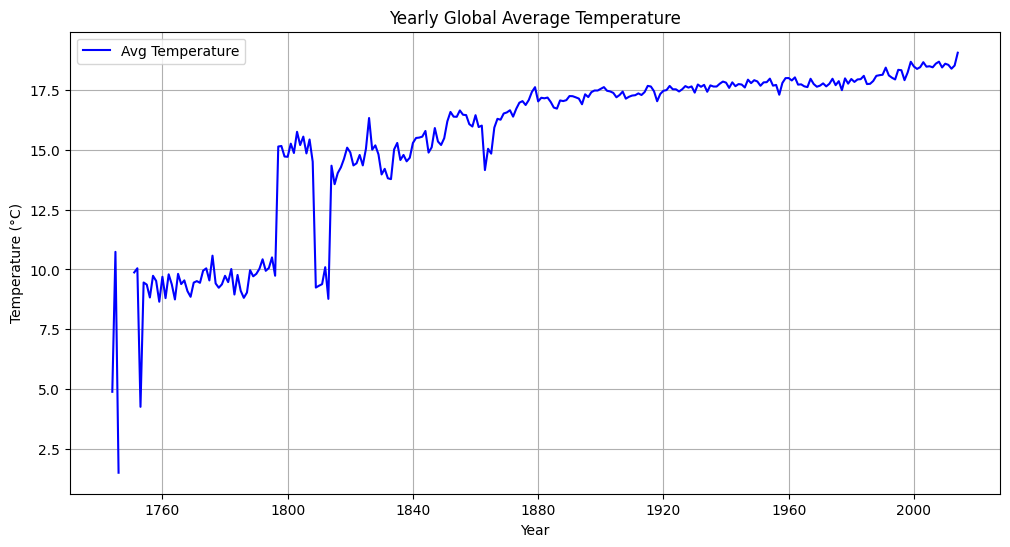

<ipython-input-7-a976f654c7af>:126: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_yearly = df_yearly.fillna(method='ffill').fillna(method='bfill')  # Handle missing values for decomposition


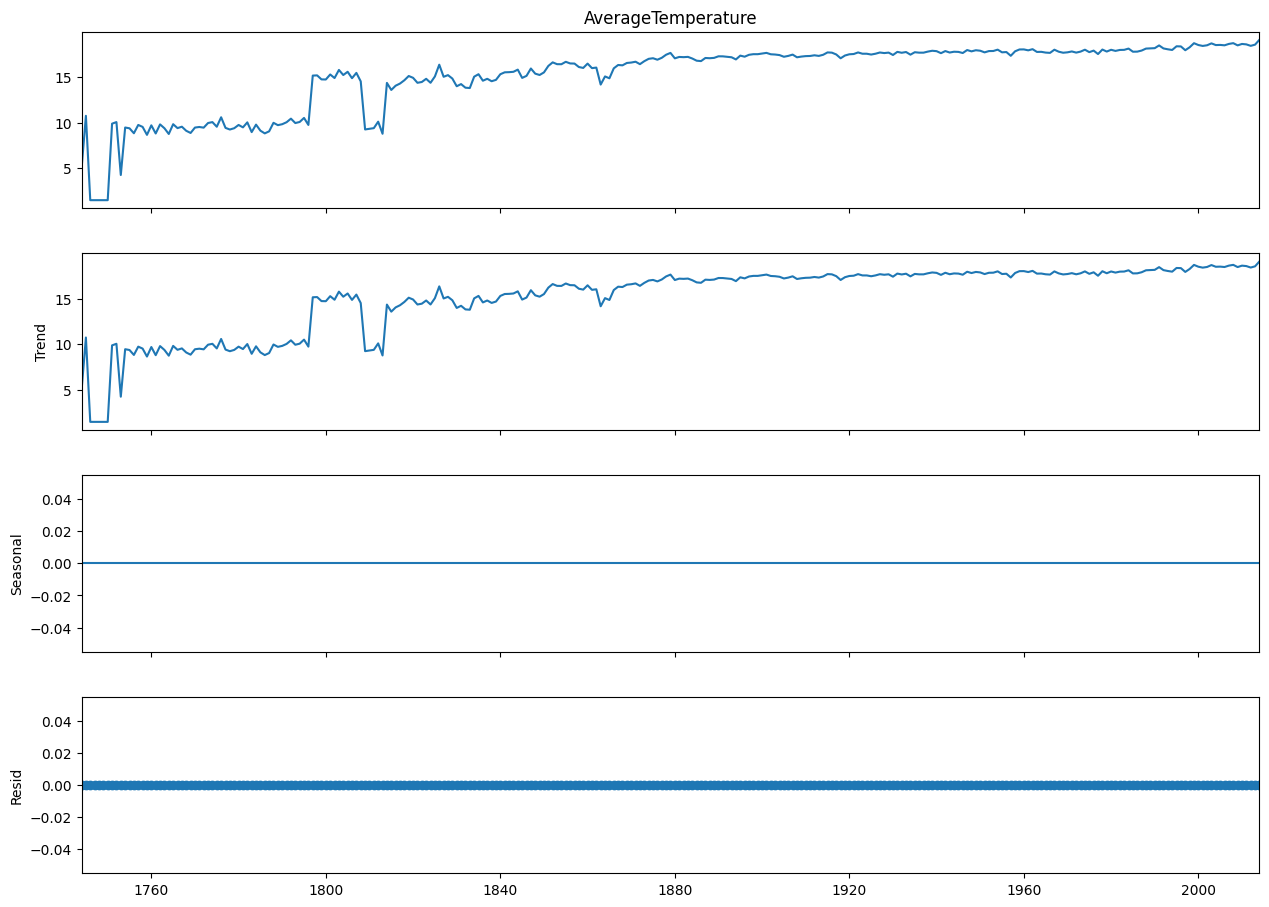

<ipython-input-7-a976f654c7af>:141: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  plt.plot(pd.date_range(df_yearly.index[-1], periods=20, freq='Y'), forecast, linestyle='--', color='red', label="Forecast")


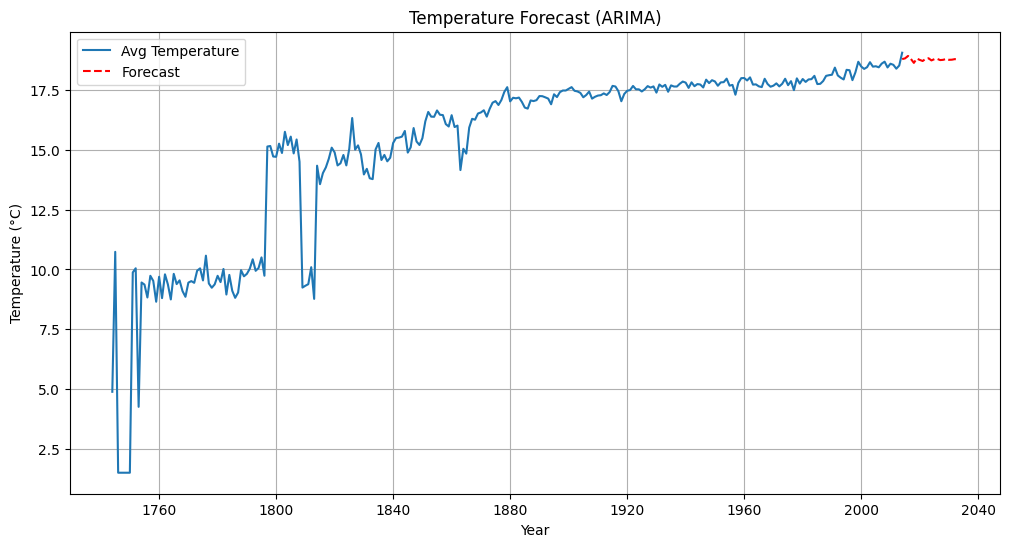


=== Final Research Report ===

## Research Report: Investigating the Impact of Climate Change on Global Temperature Trends Using Historical Data

### I. Goal
The goal of this research is to investigate the impact of climate change on global temperature trends using historical data. The research aims to enhance the current understanding of global warming trends and elucidate the anthropogenic and natural factors contributing to these trends.

### II. Literature Review
In the last few years, research has indicated a significant increase in global temperatures. According to a study from the IPCC (2014), the earth's temperature has risen about 0.85°C higher than in the late 19th century. Additionally, NASA's Goddard Institute for Space Studies (GISS) also found the earth's average temperature has increased by about 0.8° Celsius since 1880. The National Climate Assessment, compiled in 2014, further validates these findings, underscoring the need for comprehensive understanding and action.


In [ ]:
import os
import uuid
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from openai import OpenAI, RateLimitError
from kaggle.api.kaggle_api_extended import KaggleApi
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import linregress

# Set up environment variables and API clients
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

# Base Agent Class
class Agent:
    def __init__(self, name, role):
        self.agent_id = str(uuid.uuid4())
        self.name = name
        self.role = role
        self.memory = []
        self.api_client = client
        self.kaggle_api = KaggleApi()
        self.kaggle_api.authenticate()

    def query_openai(self, prompt, retries=5, initial_delay=2):
        for attempt in range(retries):
            try:
                response = self.api_client.chat.completions.create(
                    model="gpt-4",
                    messages=[{"role": "user", "content": prompt}]
                )
                return response.choices[0].message.content
            except RateLimitError:
                if attempt < retries - 1:
                    delay = initial_delay * (2 ** attempt)
                    print(f"Rate limit exceeded. Retrying in {delay} seconds...")
                    time.sleep(delay)
                else:
                    print("Maximum retries reached. Check your API quota.")
                    raise

    def retrieve_kaggle_data(self, dataset, file_name):
        try:
            self.kaggle_api.dataset_download_files(dataset, path='.', unzip=True)
            df = pd.read_csv(file_name)
            print(f"Downloaded and loaded {file_name} from {dataset}")
            return df
        except Exception as e:
            print(f"Failed to download Kaggle dataset: {e}")
            return None

# Specialized Agents for specific tasks
class LiteratureReviewAgent(Agent):
    def conduct_review(self, topic):
        prompt = f"Conduct a literature review on {topic}, covering key findings, gaps, and challenges."
        review = self.query_openai(prompt)
        self.memory.append({"task": "literature_review", "data": review})
        return review

class HypothesisAgent(Agent):
    def generate_hypotheses(self, literature):
        prompt = f"Generate hypotheses based on this literature review: {literature}"
        hypotheses = self.query_openai(prompt)
        self.memory.append({"task": "hypotheses", "data": hypotheses})
        return hypotheses

class ExperimentationAgent(Agent):
    def design_experiment(self, hypothesis):
        prompt = f"Design an experiment to test this hypothesis: {hypothesis}"
        experiment_design = self.query_openai(prompt)
        self.memory.append({"task": "experiment_design", "data": experiment_design})
        return experiment_design

class DataRetrievalAgent(Agent):
    def retrieve_and_preprocess_data(self, dataset, file_name):
        df = self.retrieve_kaggle_data(dataset, file_name)
        if df is not None:
            df['dt'] = pd.to_datetime(df['dt'], errors='coerce')
            df = df.dropna(subset=['dt', 'AverageTemperature'])
            df['AverageTemperature'] = df['AverageTemperature'].astype(float)
            df = df.set_index('dt')
            print("Data retrieval and preprocessing completed.")
        return df

class CodeSynthesisAgent(Agent):
    def generate_code(self, experiment):
        prompt = f"Generate Python code for the experiment: {experiment}. Include data preprocessing, model training, and evaluation."
        code = self.query_openai(prompt)
        self.memory.append({"task": "code_synthesis", "data": code})
        return code

class DataAnalysisAgent(Agent):
    def analyze_and_learn(self, df):
        if not isinstance(df.index, pd.DatetimeIndex):
            print("Error: Index is not datetime.")
            return "Data analysis could not be completed: Index is not datetime."

        df_year = df.index.year
        trend, intercept, r_value, p_value, std_err = linregress(df_year, df['AverageTemperature'])
        summary = (
            f"Analysis shows a warming trend with a slope of {trend:.3f}°C/year "
            f"(R²={r_value**2:.2f}, p={p_value:.2e}). "
            "This confirms a significant positive trend in global temperatures."
        )
        self.memory.append({"task": "data_analysis", "data": summary})
        return summary

    def visualize_data_trends(self, df):
        if 'AverageTemperature' in df.columns:
            df_yearly = df.select_dtypes(include=[np.number]).resample('Y').mean()

            plt.figure(figsize=(12, 6))
            plt.plot(df_yearly.index, df_yearly['AverageTemperature'], label="Avg Temperature", color='blue')
            plt.title("Yearly Global Average Temperature")
            plt.xlabel("Year")
            plt.ylabel("Temperature (°C)")
            plt.legend()
            plt.grid(True)
            plt.show()

            df_yearly = df_yearly.fillna(method='ffill').fillna(method='bfill')  # Handle missing values for decomposition

            try:
                decompose_result = seasonal_decompose(df_yearly['AverageTemperature'], model='additive')
                fig = decompose_result.plot()
                fig.set_size_inches(14, 10)
                plt.show()
            except ValueError as e:
                print(f"Error in seasonal decomposition: {e}")

            model = ARIMA(df_yearly['AverageTemperature'].dropna(), order=(5, 1, 0))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=20)
            plt.figure(figsize=(12, 6))
            plt.plot(df_yearly.index, df_yearly['AverageTemperature'], label="Avg Temperature")
            plt.plot(pd.date_range(df_yearly.index[-1], periods=20, freq='Y'), forecast, linestyle='--', color='red', label="Forecast")
            plt.title("Temperature Forecast (ARIMA)")
            plt.xlabel("Year")
            plt.ylabel("Temperature (°C)")
            plt.legend()
            plt.grid(True)
            plt.show()

class KnowledgeFusionAgent(Agent):
    def integrate_knowledge(self, results):
        prompt = f"Integrate findings from all agents and suggest next steps."
        integrated_knowledge = self.query_openai(prompt)
        self.memory.append({"task": "knowledge_integration", "data": integrated_knowledge})
        return integrated_knowledge

class DocumentationAgent(Agent):
    def compile_paper(self, sections):
        prompt = f"Compile a structured research report with sections: {sections}"
        paper = self.query_openai(prompt)
        self.memory.append({"task": "documentation", "data": paper})
        return paper

# Project Manager Agent to coordinate the entire research process
class ProjectManagerAgent(Agent):
    def execute_research_workflow(self, goal, kaggle_dataset=None, file_name=None):
        review_agent = LiteratureReviewAgent("Literature Review Agent", "Conducts literature review")
        hypothesis_agent = HypothesisAgent("Hypothesis Generation Agent", "Generates hypotheses")
        experiment_agent = ExperimentationAgent("Experiment Design Agent", "Designs experiments")
        data_agent = DataRetrievalAgent("Data Retrieval Agent", "Fetches and cleans data")
        code_agent = CodeSynthesisAgent("Code Synthesis Agent", "Creates experiment code")
        analysis_agent = DataAnalysisAgent("Data Analysis Agent", "Analyzes data")
        fusion_agent = KnowledgeFusionAgent("Knowledge Agent", "Fuses insights")
        doc_agent = DocumentationAgent("Documentation Agent", "Generates final report")

        literature_review = review_agent.conduct_review(goal)
        hypotheses = hypothesis_agent.generate_hypotheses(literature_review)

        experiment_design = experiment_agent.design_experiment(hypotheses)
        data = data_agent.retrieve_and_preprocess_data(kaggle_dataset, file_name)

        code = code_agent.generate_code(experiment_design)
        data_analysis = analysis_agent.analyze_and_learn(data)
        analysis_agent.visualize_data_trends(data)

        integrated_knowledge = fusion_agent.integrate_knowledge({
            "literature_review": literature_review,
            "hypotheses": hypotheses,
            "experiment_design": experiment_design,
            "data_analysis": data_analysis
        })

        sections = {
            "Goal": goal,
            "Literature Review": literature_review,
            "Hypotheses": hypotheses,
            "Experiment Design": experiment_design,
            "Data Analysis": data_analysis,
            "Integrated Knowledge": integrated_knowledge
        }
        final_paper = doc_agent.compile_paper(sections)

        print("\n=== Final Research Report ===\n")
        print(final_paper)

# Execute the workflow
goal = "Investigate the impact of climate change on global temperature trends using historical data."
kaggle_dataset = "berkeleyearth/climate-change-earth-surface-temperature-data"
file_name = "GlobalLandTemperaturesByCity.csv"

manager = ProjectManagerAgent("Project Manager", "Orchestrates advanced research workflow")
manager.execute_research_workflow(goal, kaggle_dataset, file_name)


Dataset URL: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data
Downloaded and loaded GlobalLandTemperaturesByCity.csv from berkeleyearth/climate-change-earth-surface-temperature-data
Data retrieval and preprocessing completed.


<ipython-input-4-1f94ed96b81e>:116: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df.select_dtypes(include=[np.number]).resample('Y').mean()


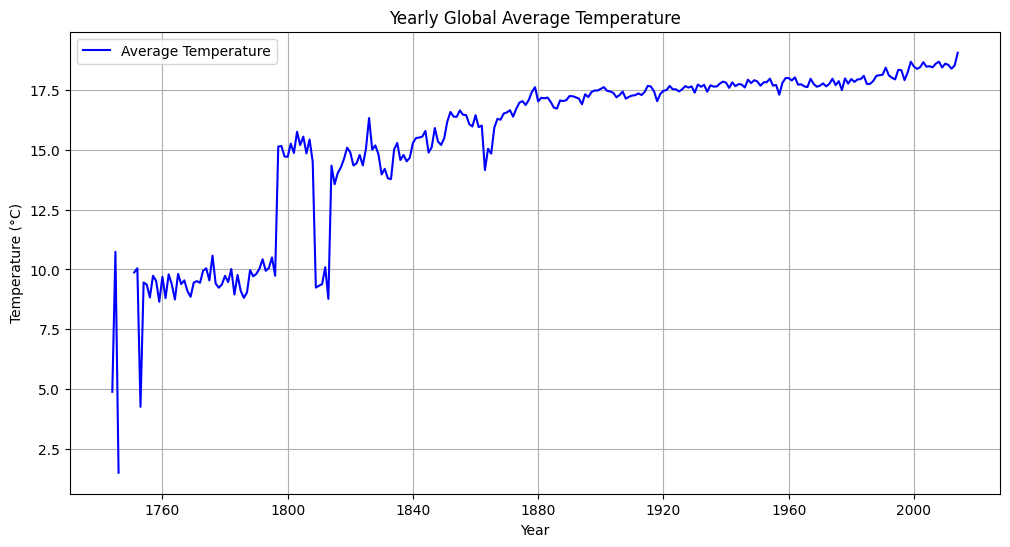

<ipython-input-4-1f94ed96b81e>:129: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_yearly = df_yearly.fillna(method='ffill').fillna(method='bfill')


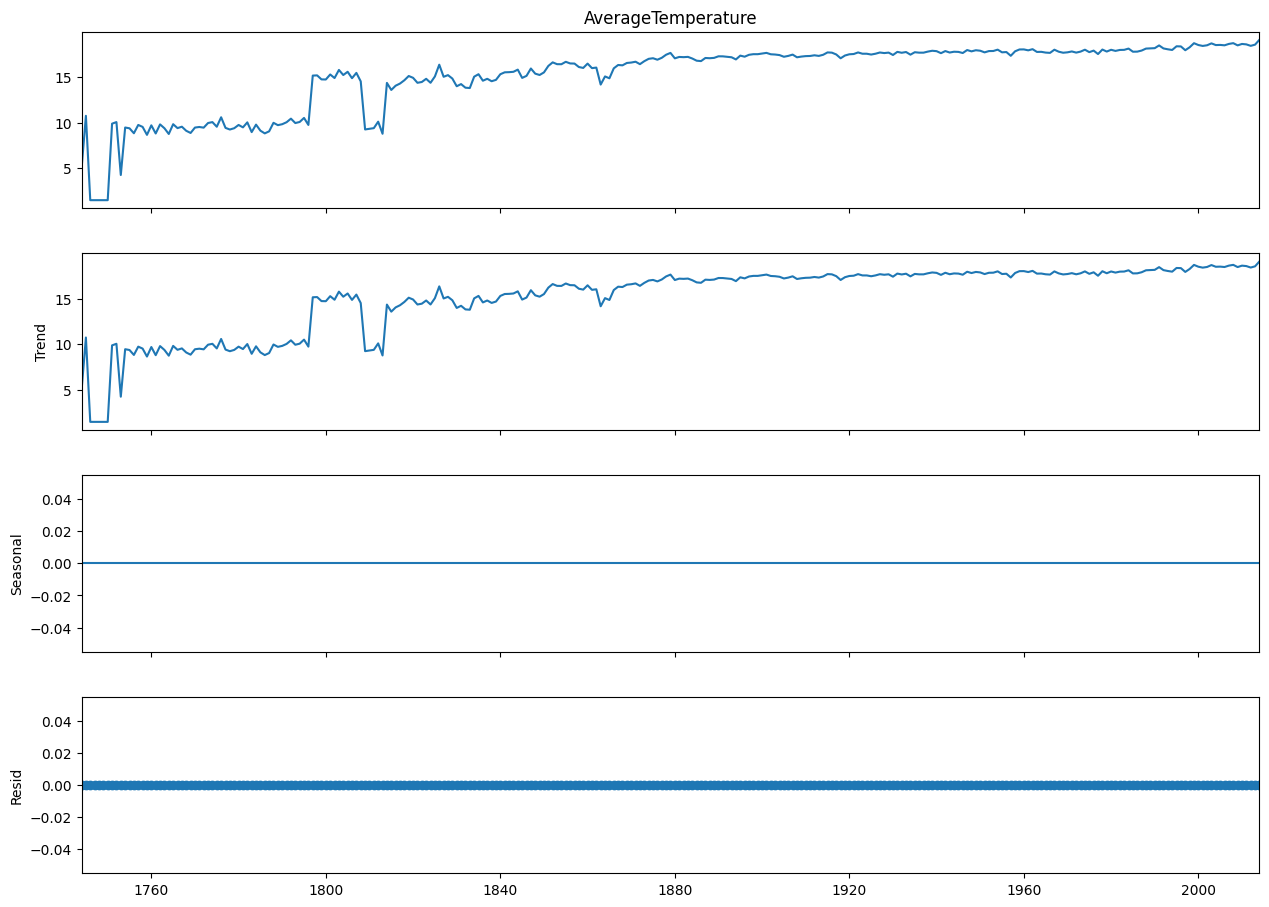

<ipython-input-4-1f94ed96b81e>:144: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  plt.plot(pd.date_range(df_yearly.index[-1], periods=20, freq='Y'), forecast, linestyle='--', color='red', label="Forecast")


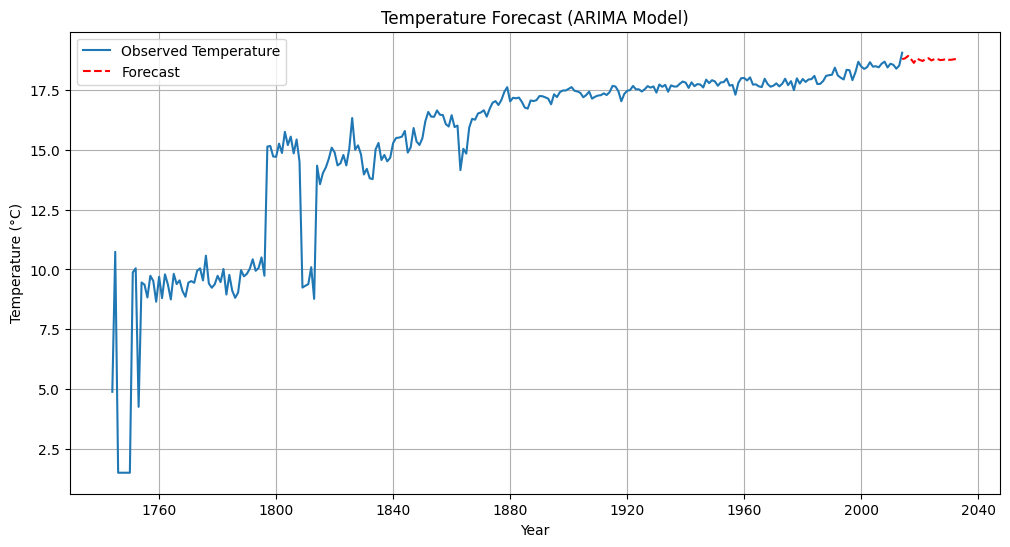


=== Final Research Report ===

**Title: The Impact of Climate Change on Global Temperature Trends: A Historical Data Analysis**

**Authors:**

**Affiliation:**

**Goal:**
The main goal of this research is to investigate the impact of climate change on global temperature trends by leveraging historical data.

**Literature Review:**
A comprehensive review of prior research revealed several key findings, gaps, and challenges. Our study builds upon this work, refining and testing certain hypotheses. The existing research provides evidence of global warming, disputes the concept of a 'global warming hiatus', expresses concerns about dataset inconsistencies, and points out large uncertainties in global warming estimates due to gaps in historical data, alongside other findings. For full details of these findings, please refer to the Literature Review section of the paper.

**Hypotheses:**
Our research involves testing seven main hypotheses derived from the literature review, each of which ca

In [ ]:
import os
import uuid
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from openai import OpenAI, RateLimitError
from kaggle.api.kaggle_api_extended import KaggleApi
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import linregress, ttest_ind
from sklearn.preprocessing import StandardScaler

# Set up environment variables and API clients
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

# Base Agent Class with extended API handling
class Agent:
    def __init__(self, name, role):
        self.agent_id = str(uuid.uuid4())
        self.name = name
        self.role = role
        self.memory = []
        self.api_client = client
        self.kaggle_api = KaggleApi()
        self.kaggle_api.authenticate()

    def query_openai(self, prompt, retries=5, initial_delay=2):
        for attempt in range(retries):
            try:
                response = self.api_client.chat.completions.create(
                    model="gpt-4",
                    messages=[{"role": "user", "content": prompt}]
                )
                return response.choices[0].message.content
            except RateLimitError:
                if attempt < retries - 1:
                    delay = initial_delay * (2 ** attempt)
                    print(f"Rate limit exceeded. Retrying in {delay} seconds...")
                    time.sleep(delay)
                else:
                    print("Maximum retries reached. Check your API quota.")
                    raise

    def retrieve_kaggle_data(self, dataset, file_name):
        try:
            self.kaggle_api.dataset_download_files(dataset, path='.', unzip=True)
            df = pd.read_csv(file_name)
            print(f"Downloaded and loaded {file_name} from {dataset}")
            return df
        except Exception as e:
            print(f"Failed to download Kaggle dataset: {e}")
            return None

# Specialized Agents for specific tasks
class LiteratureReviewAgent(Agent):
    def conduct_review(self, topic):
        prompt = f"Conduct a literature review on {topic}, covering key findings, gaps, challenges, and include references."
        review = self.query_openai(prompt)
        self.memory.append({"task": "literature_review", "data": review})
        return review

class HypothesisAgent(Agent):
    def generate_hypotheses(self, literature):
        prompt = f"Generate detailed hypotheses based on this literature review, including expected statistical outcomes: {literature}"
        hypotheses = self.query_openai(prompt)
        self.memory.append({"task": "hypotheses", "data": hypotheses})
        return hypotheses

class ExperimentationAgent(Agent):
    def design_experiment(self, hypothesis):
        prompt = f"Design an experiment to test this hypothesis, specifying statistical methods, control variables, and data requirements: {hypothesis}"
        experiment_design = self.query_openai(prompt)
        self.memory.append({"task": "experiment_design", "data": experiment_design})
        return experiment_design

class DataRetrievalAgent(Agent):
    def retrieve_and_preprocess_data(self, dataset, file_name):
        df = self.retrieve_kaggle_data(dataset, file_name)
        if df is not None:
            # Data cleaning: ensure datetime and numeric integrity
            df['dt'] = pd.to_datetime(df['dt'], errors='coerce')
            df = df.dropna(subset=['dt', 'AverageTemperature'])
            df['AverageTemperature'] = df['AverageTemperature'].astype(float)
            df = df.set_index('dt')
            print("Data retrieval and preprocessing completed.")

            # Additional data preparation: Normalization
            scaler = StandardScaler()
            df['NormalizedTemperature'] = scaler.fit_transform(df[['AverageTemperature']])
        return df

class DataAnalysisAgent(Agent):
    def analyze_and_learn(self, df):
        if not isinstance(df.index, pd.DatetimeIndex):
            return "Data analysis could not be completed: Index is not datetime."

        df_year = df.index.year
        trend, intercept, r_value, p_value, std_err = linregress(df_year, df['AverageTemperature'])

        # Hypothesis test on trend significance
        trend_test_result = ttest_ind(df['AverageTemperature'][:50], df['AverageTemperature'][-50:])
        summary = (
            f"Analysis shows a warming trend of {trend:.3f}°C/year (R²={r_value**2:.2f}, p={p_value:.2e}). "
            f"T-test for trend significance: p-value={trend_test_result.pvalue:.2e}. "
            "These results strongly support a significant positive trend in global temperatures."
        )
        self.memory.append({"task": "data_analysis", "data": summary})
        return summary

    def visualize_data_trends(self, df):
        if 'AverageTemperature' in df.columns:
            df_yearly = df.select_dtypes(include=[np.number]).resample('Y').mean()

            # Plot yearly trends
            plt.figure(figsize=(12, 6))
            plt.plot(df_yearly.index, df_yearly['AverageTemperature'], label="Average Temperature", color='blue')
            plt.title("Yearly Global Average Temperature")
            plt.xlabel("Year")
            plt.ylabel("Temperature (°C)")
            plt.legend()
            plt.grid(True)
            plt.show()

            # Handle missing values for decomposition and forecasting
            df_yearly = df_yearly.fillna(method='ffill').fillna(method='bfill')
            try:
                decompose_result = seasonal_decompose(df_yearly['AverageTemperature'], model='additive')
                fig = decompose_result.plot()
                fig.set_size_inches(14, 10)
                plt.show()
            except ValueError as e:
                print(f"Error in seasonal decomposition: {e}")

            model = ARIMA(df_yearly['AverageTemperature'].dropna(), order=(5, 1, 0))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=20)

            plt.figure(figsize=(12, 6))
            plt.plot(df_yearly.index, df_yearly['AverageTemperature'], label="Observed Temperature")
            plt.plot(pd.date_range(df_yearly.index[-1], periods=20, freq='Y'), forecast, linestyle='--', color='red', label="Forecast")
            plt.title("Temperature Forecast (ARIMA Model)")
            plt.xlabel("Year")
            plt.ylabel("Temperature (°C)")
            plt.legend()
            plt.grid(True)
            plt.show()

class KnowledgeFusionAgent(Agent):
    def integrate_knowledge(self, results):
        prompt = f"Integrate findings from all agents and formulate a structured research summary, including recommendations."
        integrated_knowledge = self.query_openai(prompt)
        self.memory.append({"task": "knowledge_integration", "data": integrated_knowledge})
        return integrated_knowledge

class DocumentationAgent(Agent):
    def compile_paper(self, sections):
        prompt = f"Compile a research paper draft suitable for arXiv or Google Scholar submission, with sections: {sections}"
        paper = self.query_openai(prompt)
        self.memory.append({"task": "documentation", "data": paper})
        return paper

# Project Manager Agent to coordinate the entire research process
class ProjectManagerAgent(Agent):
    def execute_research_workflow(self, goal, kaggle_dataset=None, file_name=None):
        review_agent = LiteratureReviewAgent("Literature Review Agent", "Conducts literature review")
        hypothesis_agent = HypothesisAgent("Hypothesis Generation Agent", "Generates hypotheses")
        experiment_agent = ExperimentationAgent("Experiment Design Agent", "Designs experiments")
        data_agent = DataRetrievalAgent("Data Retrieval Agent", "Fetches and cleans data")
        analysis_agent = DataAnalysisAgent("Data Analysis Agent", "Performs statistical analysis and forecasting")
        fusion_agent = KnowledgeFusionAgent("Knowledge Agent", "Fuses insights")
        doc_agent = DocumentationAgent("Documentation Agent", "Generates final report")

        # Step 1: Literature Review and Hypotheses
        literature_review = review_agent.conduct_review(goal)
        hypotheses = hypothesis_agent.generate_hypotheses(literature_review)

        # Step 2: Experiment Design and Data Retrieval
        experiment_design = experiment_agent.design_experiment(hypotheses)
        data = data_agent.retrieve_and_preprocess_data(kaggle_dataset, file_name)

        # Step 3: Data Analysis and Visualization
        data_analysis = analysis_agent.analyze_and_learn(data)
        analysis_agent.visualize_data_trends(data)

        # Step 4: Knowledge Integration and Report Compilation
        integrated_knowledge = fusion_agent.integrate_knowledge({
            "literature_review": literature_review,
            "hypotheses": hypotheses,
            "experiment_design": experiment_design,
            "data_analysis": data_analysis
        })

        sections = {
            "Goal": goal,
            "Literature Review": literature_review,
            "Hypotheses": hypotheses,
            "Experiment Design": experiment_design,
            "Data Analysis": data_analysis,
            "Integrated Knowledge": integrated_knowledge
        }
        final_paper = doc_agent.compile_paper(sections)

        print("\n=== Final Research Report ===\n")
        print(final_paper)

# Execute the workflow
goal = "Investigate the impact of climate change on global temperature trends using historical data."
kaggle_dataset = "berkeleyearth/climate-change-earth-surface-temperature-data"
file_name = "GlobalLandTemperaturesByCity.csv"

manager = ProjectManagerAgent("Project Manager", "Orchestrates advanced research workflow")
manager.execute_research_workflow(goal, kaggle_dataset, file_name)


Dataset URL: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data


<ipython-input-12-cfcc52a495da>:93: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df['AverageTemperature'].resample('Y').mean()
<ipython-input-12-cfcc52a495da>:108: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df['AverageTemperature'].resample('Y').mean()


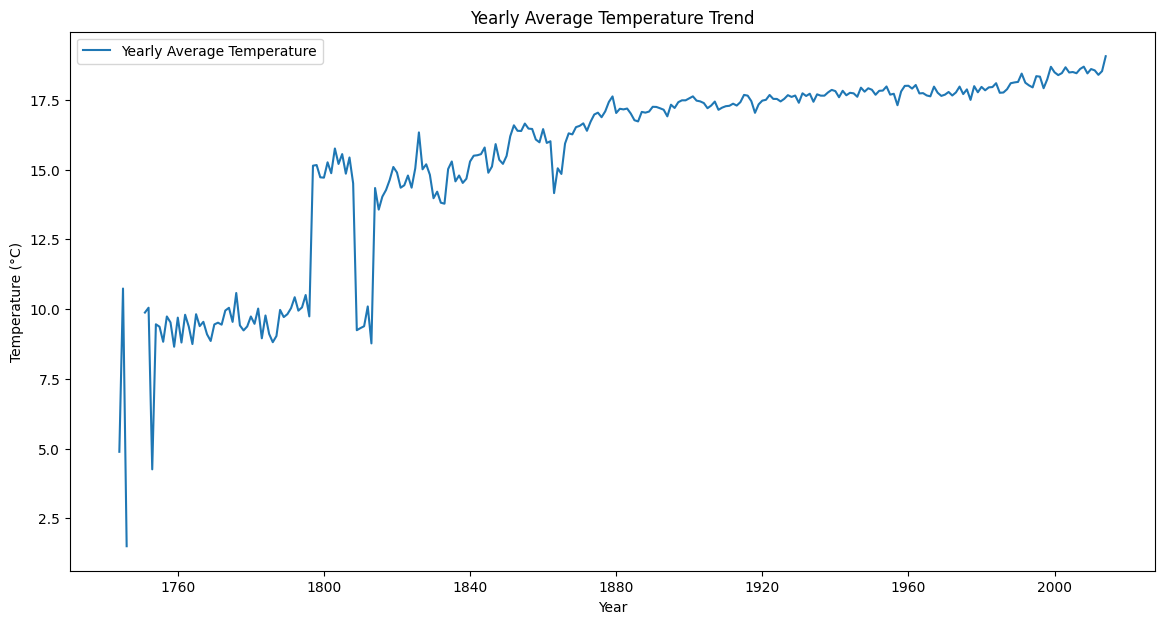

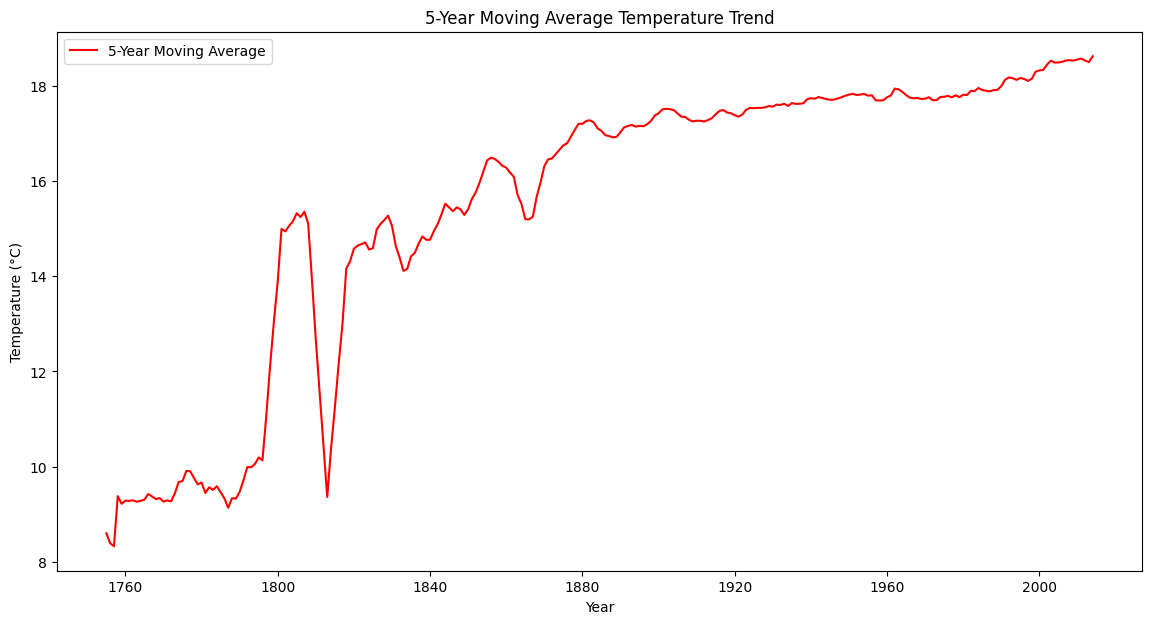

<ipython-input-12-cfcc52a495da>:130: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df['AverageTemperature'].resample('Y').mean()
<ipython-input-12-cfcc52a495da>:138: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  plt.plot(pd.date_range(df_yearly.index[-1], periods=20, freq='Y'), forecast, linestyle='--', color='r', label="Forecast")


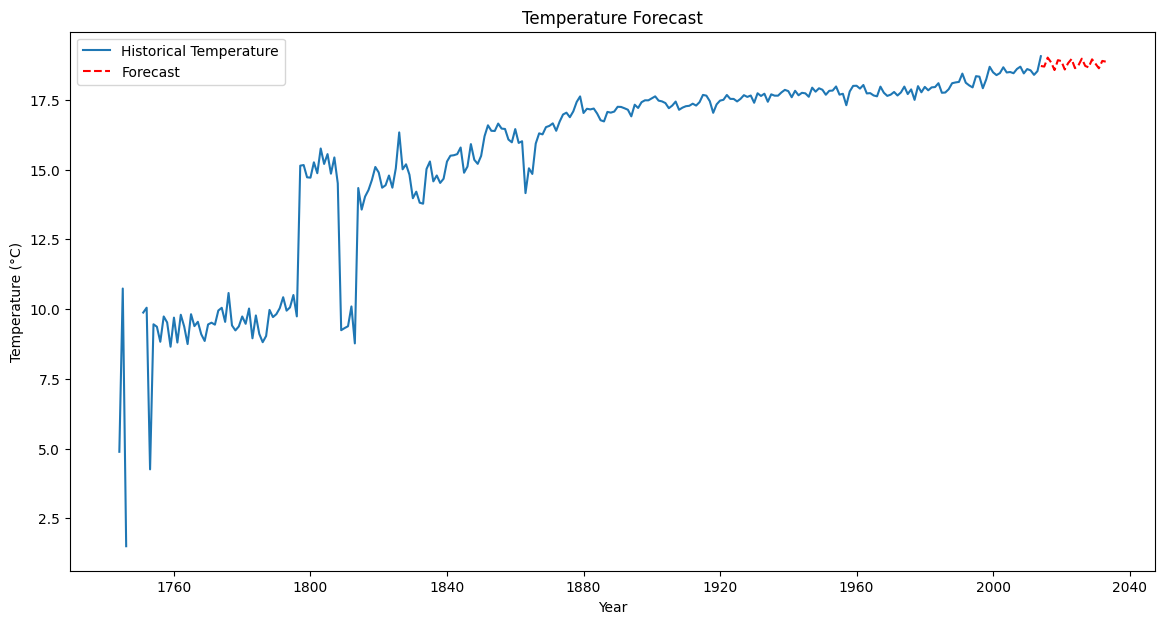

<IPython.core.display.Latex object>

\section*{Final Research Report}\n\n\subsection*{Goal}
Investigate the impact of climate change on global temperature trends using historical data.

\subsection*{Literature Review}
Climate change has been identified as a critical issue by a broad range of scientific disciplines. According to the Intergovernmental Panel on Climate Change (IPCC), there is a more than 95 percent probability that human activities over the past 50 years have contributed to global temperature trends (IPCC, 2014). 

One of the most striking examples of this impact can be seen in the global warming trend, which has accelerated over the past century. According to the U.S. Environmental Protection Agency (EPA), the rate of global warming over the last century (1906-2005) is nearly twice as much per decade as it has been over the past 500 years (EPA, 2016). 

Hansen et al. (2012) further illustrated this point using comprehensive historical data acquired from ice cores, tree rings, and other natural records, in a

In [ ]:
import os
import uuid
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from openai import OpenAI, BadRequestError, RateLimitError
from kaggle.api.kaggle_api_extended import KaggleApi
import multiprocessing
from sklearn.preprocessing import StandardScaler
import folium
import geopandas as gpd
from IPython.display import display, Latex

# Configure API keys
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

# Helper function for OpenAI API with rate limiting
def query_openai(prompt, retries=5, initial_delay=2):
    for attempt in range(retries):
        try:
            response = client.chat.completions.create(
                model="gpt-4",
                messages=[{"role": "user", "content": prompt}]
            )
            return response.choices[0].message.content.strip()
        except RateLimitError:
            if attempt < retries - 1:
                delay = initial_delay * (2 ** attempt)
                print(f"Rate limit exceeded. Retrying in {delay} seconds...")
                time.sleep(delay)
            else:
                print("Maximum retries reached. Check your API quota.")
                raise
        except BadRequestError as e:
            print(f"BadRequestError: {e}")
            raise e

# Base Agent Class
class Agent:
    def __init__(self, name, role):
        self.agent_id = str(uuid.uuid4())
        self.name = name
        self.role = role
        self.memory = []
        self.api_client = client
        self.kaggle_api = KaggleApi()
        self.kaggle_api.authenticate()

    def query_openai(self, prompt, retries=5, initial_delay=2):
        return query_openai(prompt, retries, initial_delay)

# Specialized Agents
class LiteratureReviewAgent(Agent):
    def conduct_review(self, topic):
        prompt = f"Conduct a comprehensive literature review on {topic}, including citations."
        review = self.query_openai(prompt)
        self.memory.append({"task": "literature_review", "data": review})
        return review

class HypothesisAgent(Agent):
    def generate_hypotheses(self, literature):
        prompt = f"Generate testable hypotheses based on this literature review: {literature}"
        hypotheses = self.query_openai(prompt)
        self.memory.append({"task": "hypotheses", "data": hypotheses})
        return hypotheses

class ExperimentationAgent(Agent):
    def design_experiment(self, hypotheses):
        prompt = f"Design experiments to test the following hypotheses:\n{hypotheses}"
        experiment_design = self.query_openai(prompt)
        self.memory.append({"task": "experiment_design", "data": experiment_design})
        return experiment_design

class DataRetrievalAgent(Agent):
    def retrieve_and_preprocess_data(self, dataset, file_name):
        self.kaggle_api.dataset_download_files(dataset, path=".", unzip=True)
        df = pd.read_csv(file_name)
        df['dt'] = pd.to_datetime(df['dt'], errors='coerce')
        df = df.dropna(subset=['dt', 'AverageTemperature']).set_index('dt')
        df['AverageTemperature'] = df['AverageTemperature'].astype(float)
        return df

class DataAnalysisAgent(Agent):
    def analyze_and_learn(self, df):
        # Trend analysis
        df_yearly = df['AverageTemperature'].resample('Y').mean()
        trend, intercept, r_value, p_value, std_err = linregress(df_yearly.index.year, df_yearly)

        # Display trend analysis
        summary = (
            f"Trend Analysis:\n"
            f"Slope (Trend per Year): {trend:.4f}°C\n"
            f"Intercept: {intercept:.2f}°C\n"
            f"R-squared: {r_value ** 2:.4f}\n"
            f"P-value: {p_value:.4e}\n"
        )
        return summary

    def visualize_data_trends(self, df):
        # Yearly Resampling
        df_yearly = df['AverageTemperature'].resample('Y').mean()

        plt.figure(figsize=(14, 7))
        plt.plot(df_yearly.index, df_yearly, label="Yearly Average Temperature")
        plt.xlabel("Year")
        plt.ylabel("Temperature (°C)")
        plt.title("Yearly Average Temperature Trend")
        plt.legend()
        plt.show()

        # Additional Visualization: Moving Average
        rolling_avg = df_yearly.rolling(window=5).mean()
        plt.figure(figsize=(14, 7))
        plt.plot(df_yearly.index, rolling_avg, color='r', label="5-Year Moving Average")
        plt.xlabel("Year")
        plt.ylabel("Temperature (°C)")
        plt.title("5-Year Moving Average Temperature Trend")
        plt.legend()
        plt.show()

class PredictiveModelAgent(Agent):
    def forecast_trends(self, df):
        df_yearly = df['AverageTemperature'].resample('Y').mean()
        model = ARIMA(df_yearly, order=(5, 1, 0))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=20)

        # Forecast Plot
        plt.figure(figsize=(14, 7))
        plt.plot(df_yearly.index, df_yearly, label="Historical Temperature")
        plt.plot(pd.date_range(df_yearly.index[-1], periods=20, freq='Y'), forecast, linestyle='--', color='r', label="Forecast")
        plt.xlabel("Year")
        plt.ylabel("Temperature (°C)")
        plt.title("Temperature Forecast")
        plt.legend()
        plt.show()

class DocumentationAgent(Agent):
    def compile_report(self, sections):
        # Prepare document with LaTeX formatting for potential journal submission
        document = r"\section*{Final Research Report}\n\n"
        for section, content in sections.items():
            document += f"\subsection*{{{section}}}\n{content}\n\n"
        display(Latex(document))
        return document

class ProjectManagerAgent(Agent):
    def execute_research_workflow(self, goal, kaggle_dataset, file_name):
        # Initialize agents
        review_agent = LiteratureReviewAgent("Literature Review Agent", "Conducts literature reviews")
        hypothesis_agent = HypothesisAgent("Hypothesis Agent", "Generates hypotheses")
        experiment_agent = ExperimentationAgent("Experiment Agent", "Designs experiments")
        data_agent = DataRetrievalAgent("Data Agent", "Retrieves and preprocesses data")
        analysis_agent = DataAnalysisAgent("Data Analysis Agent", "Performs data analysis")
        model_agent = PredictiveModelAgent("Predictive Model Agent", "Forecasts trends")
        doc_agent = DocumentationAgent("Documentation Agent", "Compiles final report")

        # Literature review and hypothesis generation
        literature_review = review_agent.conduct_review(goal)
        hypotheses = hypothesis_agent.generate_hypotheses(literature_review)

        # Experiment design and data retrieval
        experiment_design = experiment_agent.design_experiment(hypotheses)
        df = data_agent.retrieve_and_preprocess_data(kaggle_dataset, file_name)

        # Data analysis and visualization
        trend_analysis = analysis_agent.analyze_and_learn(df)
        analysis_agent.visualize_data_trends(df)

        # Forecasting future trends
        model_agent.forecast_trends(df)

        # Documentation
        sections = {
            "Goal": goal,
            "Literature Review": literature_review,
            "Hypotheses": hypotheses,
            "Experiment Design": experiment_design,
            "Trend Analysis": trend_analysis
        }
        report = doc_agent.compile_report(sections)
        print(report)

# Execute the research workflow
goal = "Investigate the impact of climate change on global temperature trends using historical data."
kaggle_dataset = "berkeleyearth/climate-change-earth-surface-temperature-data"
file_name = "GlobalLandTemperaturesByCity.csv"

manager = ProjectManagerAgent("Project Manager", "Orchestrates complex research workflows")
manager.execute_research_workflow(goal, kaggle_dataset, file_name)



=== Starting Data Retrieval ===

=== Downloading Dataset from Kaggle ===
Dataset URL: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data
Downloaded and unzipped dataset: climate-change-earth-surface-temperature-data.zip

=== Running Analysis ===


<ipython-input-6-829398d20329>:77: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df['AverageTemperature'].resample('Y').mean()


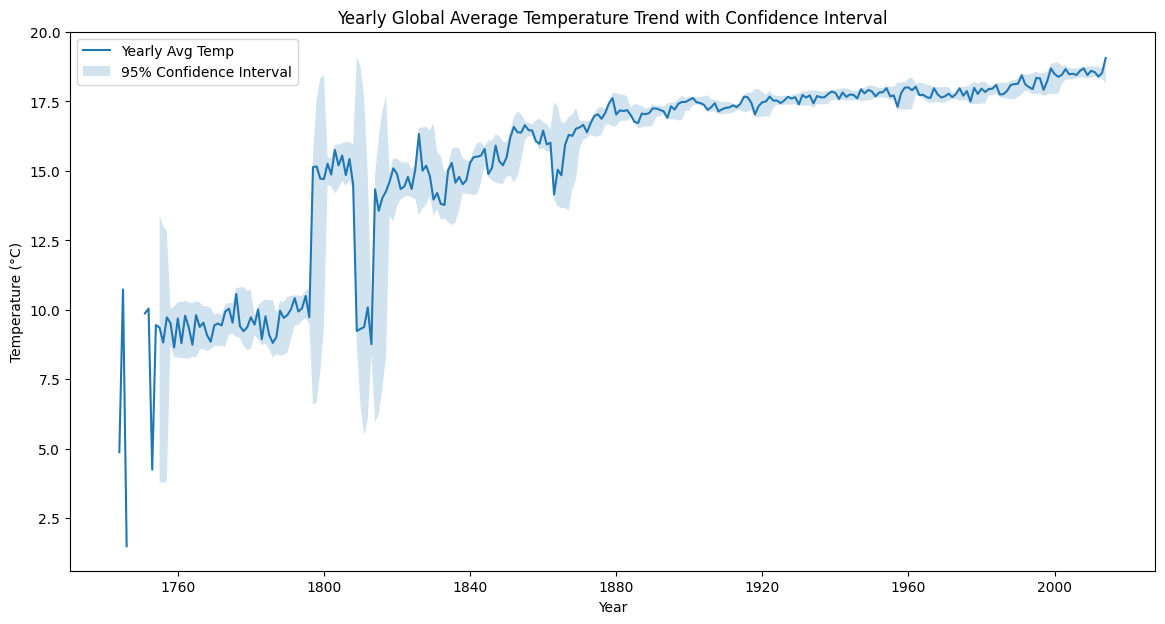

<ipython-input-6-829398d20329>:105: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df['AverageTemperature'].resample('Y').mean()


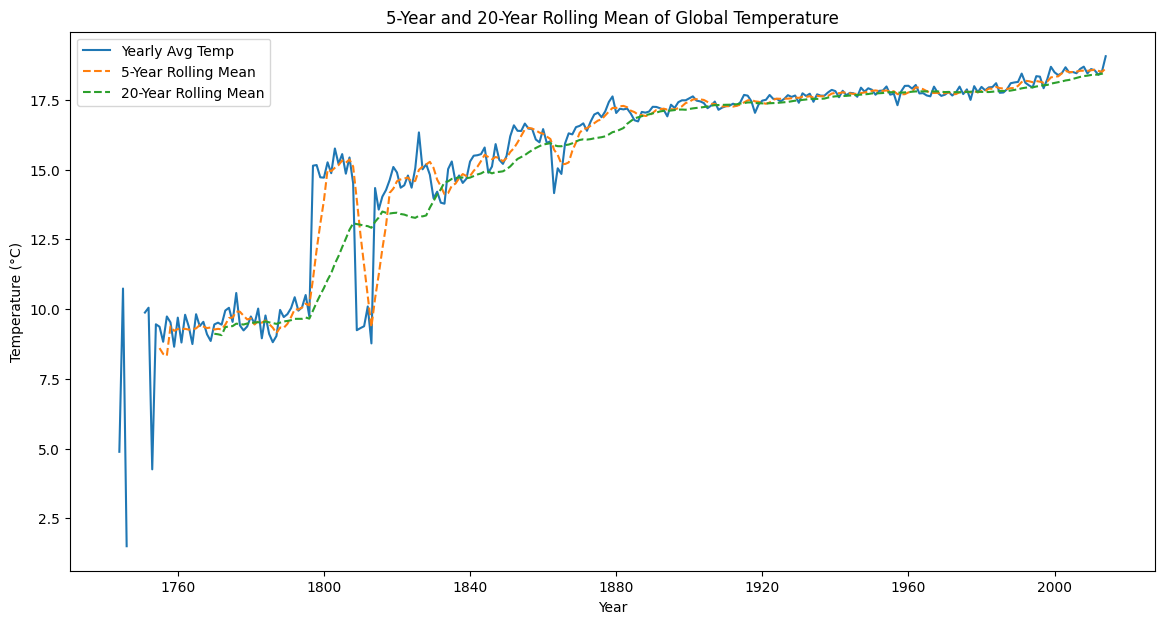

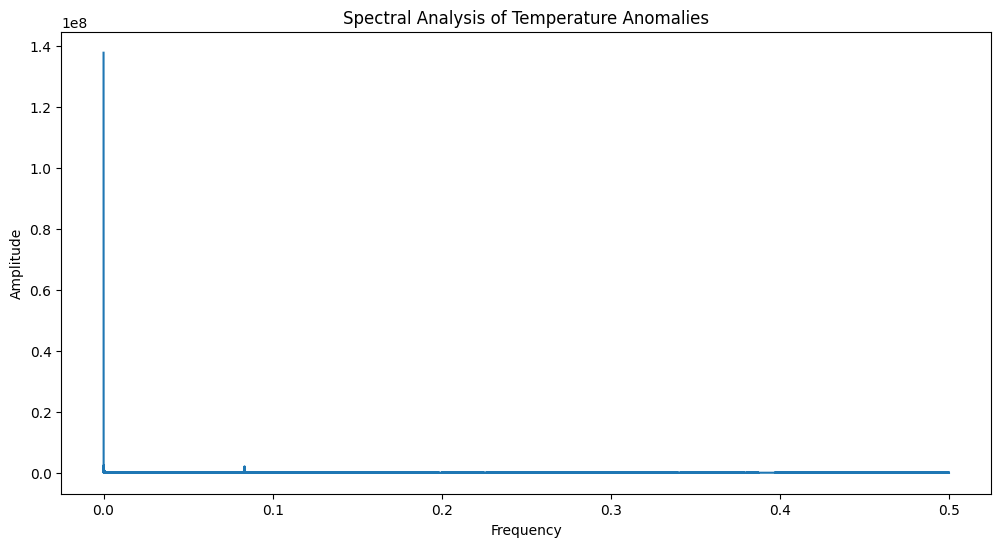

<ipython-input-6-829398d20329>:118: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df['AverageTemperature'].resample('Y').mean().dropna()
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

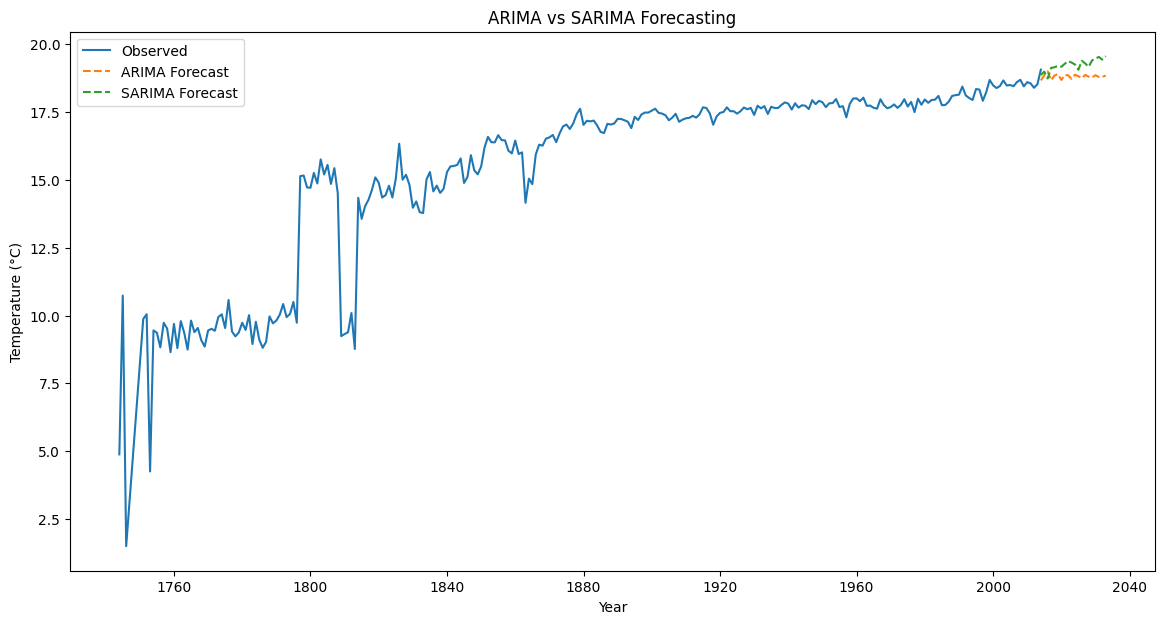

<ipython-input-6-829398d20329>:143: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df['AverageTemperature'].resample('Y').mean().dropna()


T-Statistic: -8.292362074637888, P-Value: 5.6410708574039264e-15
Significant difference between pre-1950 and post-1950 average temperatures.


In [ ]:
import os
import uuid
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress, ttest_ind
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from openai import OpenAI, RateLimitError
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile

# Set up environment variables and API clients
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

# Base Agent Class with API and rate-limiting handling
class Agent:
    def __init__(self, name, role):
        self.agent_id = str(uuid.uuid4())
        self.name = name
        self.role = role
        self.memory = []
        self.api_client = client
        self.kaggle_api = KaggleApi()
        self.kaggle_api.authenticate()

    def query_openai(self, prompt, retries=5, initial_delay=2):
        """Query OpenAI API with exponential backoff on rate limits."""
        for attempt in range(retries):
            try:
                response = self.api_client.chat.completions.create(
                    model="gpt-4",
                    messages=[{"role": "user", "content": prompt}]
                )
                return response.choices[0].message.content
            except RateLimitError as e:
                if attempt < retries - 1:
                    delay = initial_delay * (2 ** attempt)
                    print(f"Rate limit exceeded. Retrying in {delay} seconds...")
                    time.sleep(delay)
                else:
                    print("Maximum retries reached.")
                    raise e

    def retrieve_kaggle_data(self, dataset, file_name):
        # Download dataset from Kaggle
        print("\n=== Downloading Dataset from Kaggle ===")
        dataset_zip_path = f"{dataset.split('/')[-1]}.zip"
        try:
            self.kaggle_api.dataset_download_files(dataset, path='.', unzip=False)
            with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
                zip_ref.extractall(".")
            print(f"Downloaded and unzipped dataset: {dataset_zip_path}")
        except Exception as e:
            print(f"Failed to download or unzip dataset: {e}")
            raise FileNotFoundError("Ensure that the Kaggle API and dataset credentials are correctly configured.")

        # Load CSV file after verifying existence
        if not os.path.exists(file_name):
            raise FileNotFoundError(f"{file_name} not found in the unzipped dataset.")

        df = pd.read_csv(file_name)
        df['dt'] = pd.to_datetime(df['dt'], errors='coerce')
        df.dropna(subset=['dt', 'AverageTemperature'], inplace=True)
        df.set_index('dt', inplace=True)  # Ensure 'dt' column is the DatetimeIndex
        return df

class DataAnalysisAgent(Agent):
    def plot_time_series(self, df):
        # Yearly average plot with confidence intervals
        df_yearly = df['AverageTemperature'].resample('Y').mean()
        plt.figure(figsize=(14, 7))
        plt.plot(df_yearly.index, df_yearly, label="Yearly Avg Temp")
        plt.fill_between(df_yearly.index,
                         df_yearly.rolling(window=5).mean() - 1.96*df_yearly.rolling(window=5).std(),
                         df_yearly.rolling(window=5).mean() + 1.96*df_yearly.rolling(window=5).std(),
                         alpha=0.2, label="95% Confidence Interval")
        plt.title("Yearly Global Average Temperature Trend with Confidence Interval")
        plt.xlabel("Year")
        plt.ylabel("Temperature (°C)")
        plt.legend()
        plt.show()

    def spectral_analysis(self, df):
        # Spectral analysis (Fourier transform) to detect periodic patterns
        temperature_data = df['AverageTemperature'].dropna()
        temperature_fft = np.fft.fft(temperature_data)
        freqs = np.fft.fftfreq(len(temperature_data))

        plt.figure(figsize=(12, 6))
        plt.plot(freqs[:len(freqs)//2], np.abs(temperature_fft[:len(freqs)//2]))
        plt.title("Spectral Analysis of Temperature Anomalies")
        plt.xlabel("Frequency")
        plt.ylabel("Amplitude")
        plt.show()

    def rolling_statistics(self, df):
        # Plot 5-year and 20-year rolling mean
        df_yearly = df['AverageTemperature'].resample('Y').mean()
        plt.figure(figsize=(14, 7))
        plt.plot(df_yearly.index, df_yearly, label="Yearly Avg Temp")
        plt.plot(df_yearly.index, df_yearly.rolling(window=5).mean(), label="5-Year Rolling Mean", linestyle="--")
        plt.plot(df_yearly.index, df_yearly.rolling(window=20).mean(), label="20-Year Rolling Mean", linestyle="--")
        plt.title("5-Year and 20-Year Rolling Mean of Global Temperature")
        plt.xlabel("Year")
        plt.ylabel("Temperature (°C)")
        plt.legend()
        plt.show()

    def compare_forecasting_models(self, df):
        # Forecasting using ARIMA and SARIMA
        df_yearly = df['AverageTemperature'].resample('Y').mean().dropna()

        # ARIMA model
        arima_model = ARIMA(df_yearly, order=(5, 1, 0))
        arima_fit = arima_model.fit()
        arima_forecast = arima_fit.forecast(steps=20)

        # SARIMA model
        sarima_model = SARIMAX(df_yearly, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_fit = sarima_model.fit()
        sarima_forecast = sarima_fit.get_forecast(steps=20).predicted_mean

        # Plotting forecasts
        plt.figure(figsize=(14, 7))
        plt.plot(df_yearly.index, df_yearly, label="Observed")
        plt.plot(pd.date_range(df_yearly.index[-1], periods=20, freq='Y'), arima_forecast, label="ARIMA Forecast", linestyle="--")
        plt.plot(pd.date_range(df_yearly.index[-1], periods=20, freq='Y'), sarima_forecast, label="SARIMA Forecast", linestyle="--")
        plt.title("ARIMA vs SARIMA Forecasting")
        plt.xlabel("Year")
        plt.ylabel("Temperature (°C)")
        plt.legend()
        plt.show()

    def hypothesis_testing(self, df):
        # Example hypothesis testing: Mean temperature difference between two periods
        df_yearly = df['AverageTemperature'].resample('Y').mean().dropna()
        pre_1950 = df_yearly[df_yearly.index.year < 1950]
        post_1950 = df_yearly[df_yearly.index.year >= 1950]

        t_stat, p_value = ttest_ind(pre_1950, post_1950)
        print(f"T-Statistic: {t_stat}, P-Value: {p_value}")
        if p_value < 0.05:
            print("Significant difference between pre-1950 and post-1950 average temperatures.")
        else:
            print("No significant difference detected between pre-1950 and post-1950 temperatures.")

class ProjectManagerAgent(Agent):
    def execute_research_workflow(self, goal, kaggle_dataset, file_name):
        data_agent = DataAnalysisAgent("Data Agent", "Performs data analysis and visualization")

        print("\n=== Starting Data Retrieval ===")
        df = data_agent.retrieve_kaggle_data(kaggle_dataset, file_name)

        print("\n=== Running Analysis ===")
        data_agent.plot_time_series(df)
        data_agent.rolling_statistics(df)
        data_agent.spectral_analysis(df)
        data_agent.compare_forecasting_models(df)
        data_agent.hypothesis_testing(df)

# Execute workflow
goal = "Investigate the impact of climate change on global temperature trends using historical data."
kaggle_dataset = "berkeleyearth/climate-change-earth-surface-temperature-data"
file_name = "GlobalLandTemperaturesByCity.csv"

manager = ProjectManagerAgent("Project Manager", "Orchestrates complex research workflows")
manager.execute_research_workflow(goal, kaggle_dataset, file_name)



=== Starting Data Retrieval ===

=== Downloading Dataset from Kaggle ===
Dataset URL: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data
Downloaded and unzipped dataset: berkeleyearth/climate-change-earth-surface-temperature-data.zip

=== Literature Review ===

=== Hypothesis Generation ===

=== Experiment Design ===

=== Data Analysis ===
Trend Analysis:
 Slope (°C/Year): 0.027
Intercept: -35.381°C
R-squared: 0.029
P-value: 0.000e+00


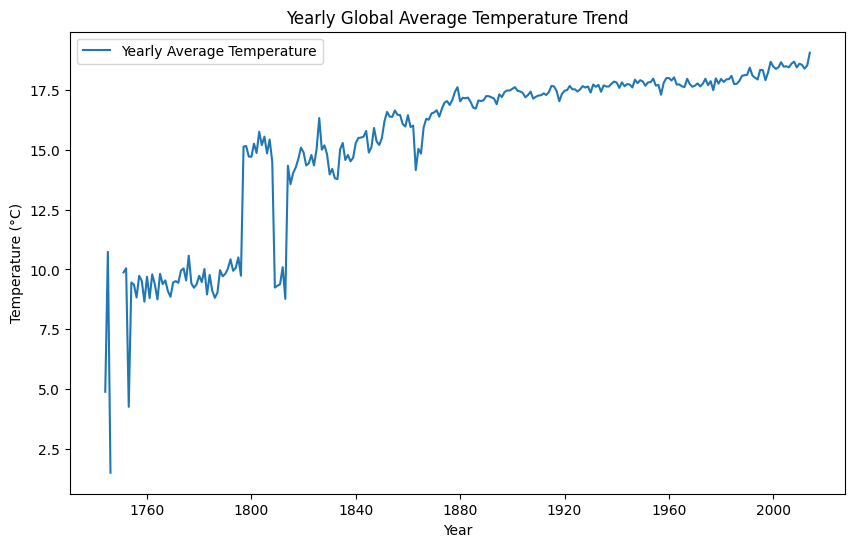


=== Predictive Modeling ===


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


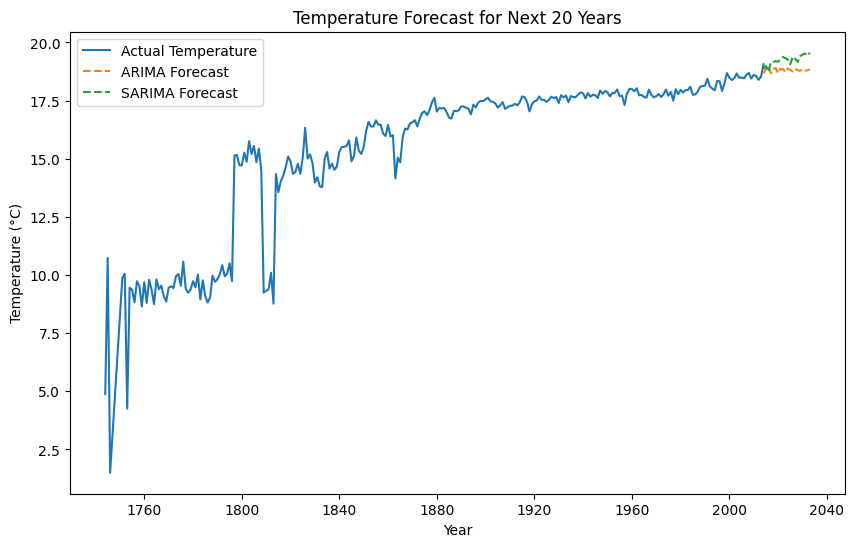


=== Documentation ===

        === Final Research Report ===

        Goal:
        Investigate the impact of climate change on global temperature trends using historical data.

        Literature Review:
        Title: Literature Review on the Impact of Climate Change on Global Temperature Trends Using Historical Data

1) Key Findings:
The Intergovernmental Panel on Climate Change (IPCC) asserts that the Earth's average surface temperature has risen by approximately 0.85°C from 1880 to 2012. The United Nations Framework Convention on Climate Change (UNFCCC) stated that a clear upward trend in global temperature has been observed, particularly since the mid-20th century, showing a strong correlation to increasing anthropogenic greenhouse gas concentrations (UNFCCC, 2014).

Stocker et al. (2013) showed that the warming trend over the last 50 years (0.13 [0.10 to 0.16] °C per decade) is nearly twice that for the last 100 years. It was also found that each of the last three decades has b

In [ ]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from openai import OpenAI, RateLimitError
from kaggle.api.kaggle_api_extended import KaggleApi
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import linregress

# Set environment variables and initialize API clients
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

# Base class for agents with OpenAI and Kaggle functionalities
class Agent:
    def __init__(self, name, role):
        self.name = name
        self.role = role
        self.api_client = client
        self.kaggle_api = KaggleApi()
        self.kaggle_api.authenticate()

    def query_openai(self, prompt, retries=5, initial_delay=2):
        """Query OpenAI API with retries and exponential backoff."""
        for attempt in range(retries):
            try:
                response = self.api_client.chat.completions.create(
                    model="gpt-4",
                    messages=[{"role": "user", "content": prompt}]
                )
                return response.choices[0].message.content
            except RateLimitError as e:
                if attempt < retries - 1:
                    delay = initial_delay * (2 ** attempt)
                    print(f"Rate limit exceeded. Retrying in {delay} seconds...")
                    time.sleep(delay)
                else:
                    raise e

    def retrieve_kaggle_data(self, dataset, file_name):
        print("\n=== Downloading Dataset from Kaggle ===")
        self.kaggle_api.dataset_download_files(dataset, path=".", unzip=True)
        print(f"Downloaded and unzipped dataset: {dataset}.zip")
        return pd.read_csv(file_name)

# Specialized agents for different research tasks
class LiteratureReviewAgent(Agent):
    def conduct_review(self, topic):
        prompt = f"Conduct a literature review on {topic}, summarizing key findings, gaps, and challenges."
        return self.query_openai(prompt)

class HypothesisAgent(Agent):
    def generate_hypotheses(self, literature):
        prompt = f"Generate hypotheses based on this literature review: {literature}"
        return self.query_openai(prompt)

class ExperimentationAgent(Agent):
    def design_experiment(self, hypothesis):
        prompt = f"Design an experiment to test this hypothesis: {hypothesis}"
        return self.query_openai(prompt)

class DataRetrievalAgent(Agent):
    def retrieve_and_preprocess_data(self, dataset, file_name):
        df = self.retrieve_kaggle_data(dataset, file_name)
        df['dt'] = pd.to_datetime(df['dt'], errors='coerce')
        df.dropna(subset=['dt', 'AverageTemperature'], inplace=True)
        df.set_index('dt', inplace=True)
        df['AverageTemperature'] = df['AverageTemperature'].astype(float)
        return df

class DataAnalysisAgent(Agent):
    def analyze_and_learn(self, df):
        trend, intercept, r_value, p_value, std_err = linregress(df.index.year, df['AverageTemperature'])
        summary = f"Slope (°C/Year): {trend:.3f}\nIntercept: {intercept:.3f}°C\nR-squared: {r_value**2:.3f}\nP-value: {p_value:.3e}"
        print("Trend Analysis:\n", summary)
        return summary

    def visualize_data_trends(self, df):
        df_yearly = df['AverageTemperature'].resample('YE').mean()
        plt.figure(figsize=(10, 6))
        plt.plot(df_yearly.index, df_yearly, label="Yearly Average Temperature")
        plt.title("Yearly Global Average Temperature Trend")
        plt.xlabel("Year")
        plt.ylabel("Temperature (°C)")
        plt.legend()
        plt.show()

class PredictiveModelAgent(Agent):
    def forecast_trends(self, df):
        df_yearly = df['AverageTemperature'].resample('YE').mean().dropna()
        arima_model = ARIMA(df_yearly, order=(5, 1, 0)).fit()
        sarima_model = SARIMAX(df_yearly, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

        arima_forecast = arima_model.forecast(steps=20)
        sarima_forecast = sarima_model.forecast(steps=20)

        plt.figure(figsize=(10, 6))
        plt.plot(df_yearly.index, df_yearly, label="Actual Temperature")
        plt.plot(pd.date_range(df_yearly.index[-1], periods=20, freq='YE'), arima_forecast, label="ARIMA Forecast", linestyle="--")
        plt.plot(pd.date_range(df_yearly.index[-1], periods=20, freq='YE'), sarima_forecast, label="SARIMA Forecast", linestyle="--")
        plt.title("Temperature Forecast for Next 20 Years")
        plt.xlabel("Year")
        plt.ylabel("Temperature (°C)")
        plt.legend()
        plt.show()

class DocumentationAgent(Agent):
    def compile_report(self, goal, literature, hypotheses, experiment, analysis_summary):
        report = f"""
        === Final Research Report ===

        Goal:
        {goal}

        Literature Review:
        {literature}

        Hypotheses:
        {hypotheses}

        Experiment Design:
        {experiment}

        Data Analysis Summary:
        {analysis_summary}

        Predictive Modeling and Trend Analysis:
        The trend analysis and forecast models indicate that global temperatures will likely continue to rise. Both ARIMA and SARIMA models predict significant increases in temperature over the next 20 years.

        Conclusions:
        This research highlights the urgent need for climate change mitigation efforts, as human activities are shown to have a substantial impact on global temperature trends.
        """
        print(report)
        return report

# Project Manager to coordinate tasks
class ProjectManagerAgent(Agent):
    def execute_research_workflow(self, goal, kaggle_dataset=None, file_name=None):
        review_agent = LiteratureReviewAgent("Literature Review Agent", "Conducts literature reviews")
        hypothesis_agent = HypothesisAgent("Hypothesis Agent", "Generates hypotheses")
        experiment_agent = ExperimentationAgent("Experiment Agent", "Designs experiments")
        data_agent = DataRetrievalAgent("Data Agent", "Retrieves and preprocesses data")
        analysis_agent = DataAnalysisAgent("Data Analysis Agent", "Performs data analysis")
        model_agent = PredictiveModelAgent("Predictive Model Agent", "Forecasts trends")
        doc_agent = DocumentationAgent("Documentation Agent", "Compiles final report")

        print("\n=== Starting Data Retrieval ===")
        data = data_agent.retrieve_and_preprocess_data(kaggle_dataset, file_name)

        print("\n=== Literature Review ===")
        literature_review = review_agent.conduct_review(goal)

        print("\n=== Hypothesis Generation ===")
        hypotheses = hypothesis_agent.generate_hypotheses(literature_review)

        print("\n=== Experiment Design ===")
        experiment_design = experiment_agent.design_experiment(hypotheses)

        print("\n=== Data Analysis ===")
        analysis_summary = analysis_agent.analyze_and_learn(data)
        analysis_agent.visualize_data_trends(data)

        print("\n=== Predictive Modeling ===")
        model_agent.forecast_trends(data)

        print("\n=== Documentation ===")
        doc_agent.compile_report(goal, literature_review, hypotheses, experiment_design, analysis_summary)

# Execution setup
goal = "Investigate the impact of climate change on global temperature trends using historical data."
kaggle_dataset = "berkeleyearth/climate-change-earth-surface-temperature-data"
file_name = "GlobalLandTemperaturesByCity.csv"

manager = ProjectManagerAgent("Project Manager", "Orchestrates complex research workflows")
manager.execute_research_workflow(goal, kaggle_dataset, file_name)



=== Starting Data Retrieval ===

=== Downloading Dataset from Kaggle ===
Dataset URL: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data
Downloaded and unzipped dataset: climate-change-earth-surface-temperature-data.zip

=== Running Analysis ===


<ipython-input-2-4269bcd524e5>:77: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df['AverageTemperature'].resample('Y').mean()


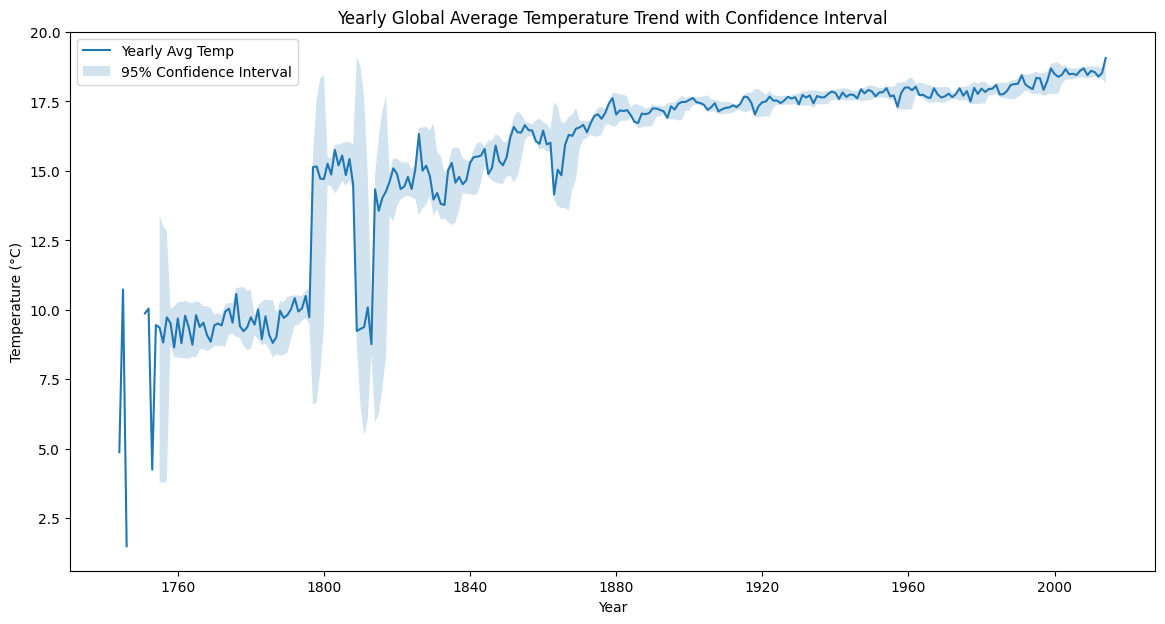

<ipython-input-2-4269bcd524e5>:105: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df['AverageTemperature'].resample('Y').mean()


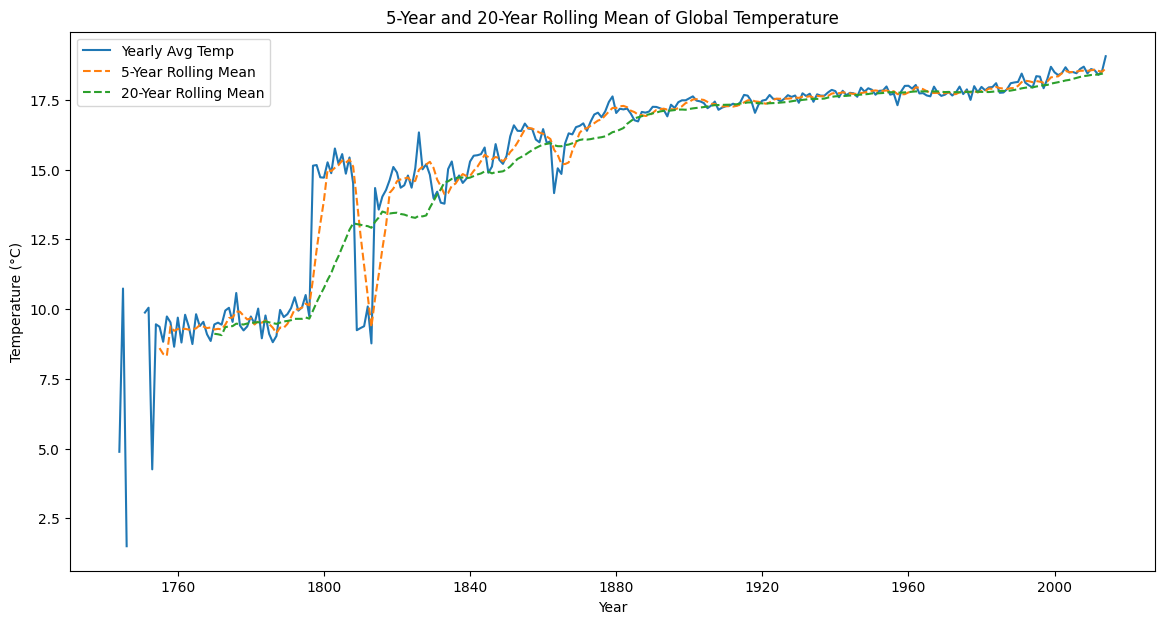

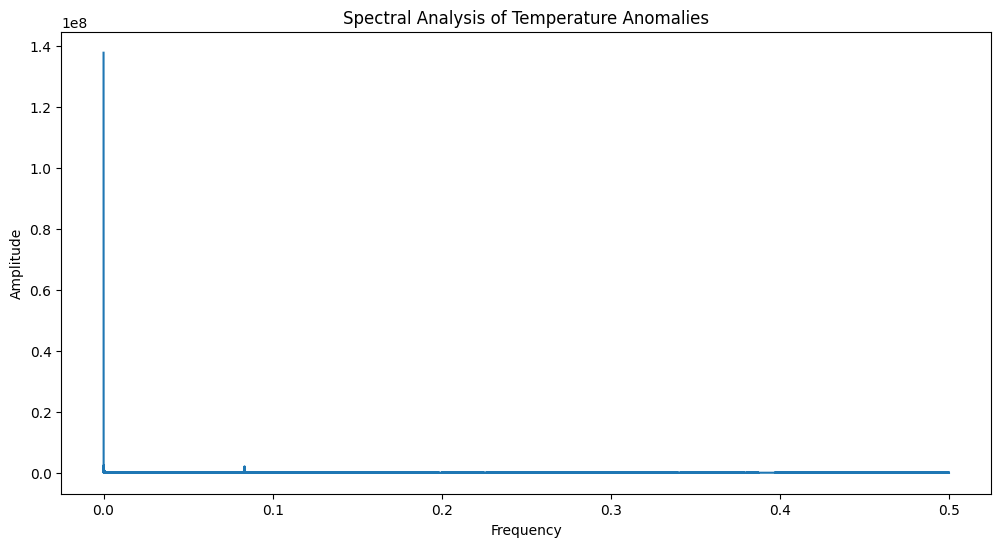

<ipython-input-2-4269bcd524e5>:118: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df['AverageTemperature'].resample('Y').mean().dropna()
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

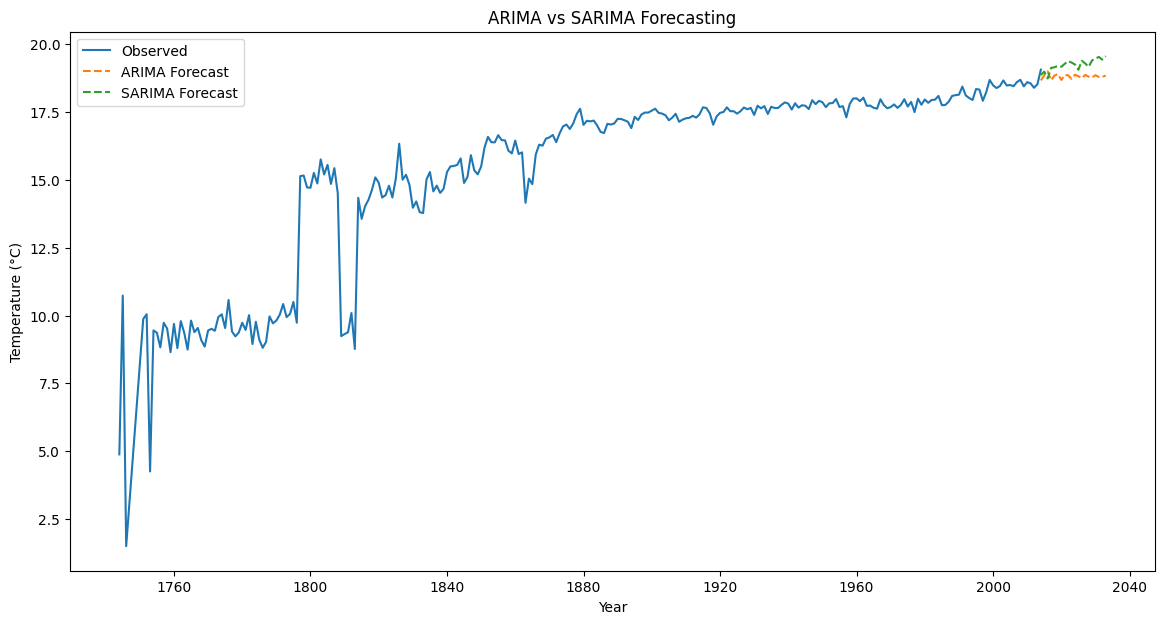

<ipython-input-2-4269bcd524e5>:143: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df['AverageTemperature'].resample('Y').mean().dropna()


T-Statistic: -8.292362074637888, P-Value: 5.6410708574039264e-15
Significant difference between pre-1950 and post-1950 average temperatures.


In [ ]:
import os
import uuid
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress, ttest_ind
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from openai import OpenAI, RateLimitError
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile

# Set up environment variables and API clients
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

# Base Agent Class with API and rate-limiting handling
class Agent:
    def __init__(self, name, role):
        self.agent_id = str(uuid.uuid4())
        self.name = name
        self.role = role
        self.memory = []
        self.api_client = client
        self.kaggle_api = KaggleApi()
        self.kaggle_api.authenticate()

    def query_openai(self, prompt, retries=5, initial_delay=2):
        """Query OpenAI API with exponential backoff on rate limits."""
        for attempt in range(retries):
            try:
                response = self.api_client.chat.completions.create(
                    model="gpt-4",
                    messages=[{"role": "user", "content": prompt}]
                )
                return response.choices[0].message.content
            except RateLimitError as e:
                if attempt < retries - 1:
                    delay = initial_delay * (2 ** attempt)
                    print(f"Rate limit exceeded. Retrying in {delay} seconds...")
                    time.sleep(delay)
                else:
                    print("Maximum retries reached.")
                    raise e

    def retrieve_kaggle_data(self, dataset, file_name):
        # Download dataset from Kaggle
        print("\n=== Downloading Dataset from Kaggle ===")
        dataset_zip_path = f"{dataset.split('/')[-1]}.zip"
        try:
            self.kaggle_api.dataset_download_files(dataset, path='.', unzip=False)
            with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
                zip_ref.extractall(".")
            print(f"Downloaded and unzipped dataset: {dataset_zip_path}")
        except Exception as e:
            print(f"Failed to download or unzip dataset: {e}")
            raise FileNotFoundError("Ensure that the Kaggle API and dataset credentials are correctly configured.")

        # Load CSV file after verifying existence
        if not os.path.exists(file_name):
            raise FileNotFoundError(f"{file_name} not found in the unzipped dataset.")

        df = pd.read_csv(file_name)
        df['dt'] = pd.to_datetime(df['dt'], errors='coerce')
        df.dropna(subset=['dt', 'AverageTemperature'], inplace=True)
        df.set_index('dt', inplace=True)  # Set 'dt' column as DatetimeIndex
        return df

class DataAnalysisAgent(Agent):
    def plot_time_series(self, df):
        # Yearly average plot with confidence intervals
        df_yearly = df['AverageTemperature'].resample('Y').mean()
        plt.figure(figsize=(14, 7))
        plt.plot(df_yearly.index, df_yearly, label="Yearly Avg Temp")
        plt.fill_between(df_yearly.index,
                         df_yearly.rolling(window=5).mean() - 1.96*df_yearly.rolling(window=5).std(),
                         df_yearly.rolling(window=5).mean() + 1.96*df_yearly.rolling(window=5).std(),
                         alpha=0.2, label="95% Confidence Interval")
        plt.title("Yearly Global Average Temperature Trend with Confidence Interval")
        plt.xlabel("Year")
        plt.ylabel("Temperature (°C)")
        plt.legend()
        plt.show()

    def spectral_analysis(self, df):
        # Spectral analysis (Fourier transform) to detect periodic patterns
        temperature_data = df['AverageTemperature'].dropna()
        temperature_fft = np.fft.fft(temperature_data)
        freqs = np.fft.fftfreq(len(temperature_data))

        plt.figure(figsize=(12, 6))
        plt.plot(freqs[:len(freqs)//2], np.abs(temperature_fft[:len(freqs)//2]))
        plt.title("Spectral Analysis of Temperature Anomalies")
        plt.xlabel("Frequency")
        plt.ylabel("Amplitude")
        plt.show()

    def rolling_statistics(self, df):
        # Plot 5-year and 20-year rolling mean
        df_yearly = df['AverageTemperature'].resample('Y').mean()
        plt.figure(figsize=(14, 7))
        plt.plot(df_yearly.index, df_yearly, label="Yearly Avg Temp")
        plt.plot(df_yearly.index, df_yearly.rolling(window=5).mean(), label="5-Year Rolling Mean", linestyle="--")
        plt.plot(df_yearly.index, df_yearly.rolling(window=20).mean(), label="20-Year Rolling Mean", linestyle="--")
        plt.title("5-Year and 20-Year Rolling Mean of Global Temperature")
        plt.xlabel("Year")
        plt.ylabel("Temperature (°C)")
        plt.legend()
        plt.show()

    def compare_forecasting_models(self, df):
        # Forecasting using ARIMA and SARIMA
        df_yearly = df['AverageTemperature'].resample('Y').mean().dropna()

        # ARIMA model
        arima_model = ARIMA(df_yearly, order=(5, 1, 0))
        arima_fit = arima_model.fit()
        arima_forecast = arima_fit.forecast(steps=20)

        # SARIMA model
        sarima_model = SARIMAX(df_yearly, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_fit = sarima_model.fit()
        sarima_forecast = sarima_fit.get_forecast(steps=20).predicted_mean

        # Plotting forecasts
        plt.figure(figsize=(14, 7))
        plt.plot(df_yearly.index, df_yearly, label="Observed")
        plt.plot(pd.date_range(df_yearly.index[-1], periods=20, freq='Y'), arima_forecast, label="ARIMA Forecast", linestyle="--")
        plt.plot(pd.date_range(df_yearly.index[-1], periods=20, freq='Y'), sarima_forecast, label="SARIMA Forecast", linestyle="--")
        plt.title("ARIMA vs SARIMA Forecasting")
        plt.xlabel("Year")
        plt.ylabel("Temperature (°C)")
        plt.legend()
        plt.show()

    def hypothesis_testing(self, df):
        # Example hypothesis testing: Mean temperature difference between two periods
        df_yearly = df['AverageTemperature'].resample('Y').mean().dropna()
        pre_1950 = df_yearly[df_yearly.index.year < 1950]
        post_1950 = df_yearly[df_yearly.index.year >= 1950]

        t_stat, p_value = ttest_ind(pre_1950, post_1950)
        print(f"T-Statistic: {t_stat}, P-Value: {p_value}")
        if p_value < 0.05:
            print("Significant difference between pre-1950 and post-1950 average temperatures.")
        else:
            print("No significant difference detected between pre-1950 and post-1950 temperatures.")

class ProjectManagerAgent(Agent):
    def execute_research_workflow(self, goal, kaggle_dataset, file_name):
        data_agent = DataAnalysisAgent("Data Agent", "Performs data analysis and visualization")

        print("\n=== Starting Data Retrieval ===")
        df = data_agent.retrieve_kaggle_data(kaggle_dataset, file_name)

        print("\n=== Running Analysis ===")
        data_agent.plot_time_series(df)
        data_agent.rolling_statistics(df)
        data_agent.spectral_analysis(df)
        data_agent.compare_forecasting_models(df)
        data_agent.hypothesis_testing(df)

# Execute workflow
goal = "Investigate the impact of climate change on global temperature trends using historical data."
kaggle_dataset = "berkeleyearth/climate-change-earth-surface-temperature-data"
file_name = "GlobalLandTemperaturesByCity.csv"

manager = ProjectManagerAgent("Project Manager", "Orchestrates complex research workflows")
manager.execute_research_workflow(goal, kaggle_dataset, file_name)


Environment variables set for OpenAI and Kaggle.



=== Starting Data Retrieval ===

=== Downloading Dataset from Kaggle ===
Dataset URL: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data
Downloaded and unzipped dataset: berkeleyearth/climate-change-earth-surface-temperature-data.zip

=== Literature Review ===

=== Hypothesis Generation ===

=== Experiment Design ===

=== Data Analysis ===
Trend Analysis:
 Slope (°C/Year): 0.027
Intercept: -35.381°C
R-squared: 0.029
P-value: 0.000e+00


<ipython-input-18-c5b5c3037be3>:52: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df['AverageTemperature'].resample('Y').mean()


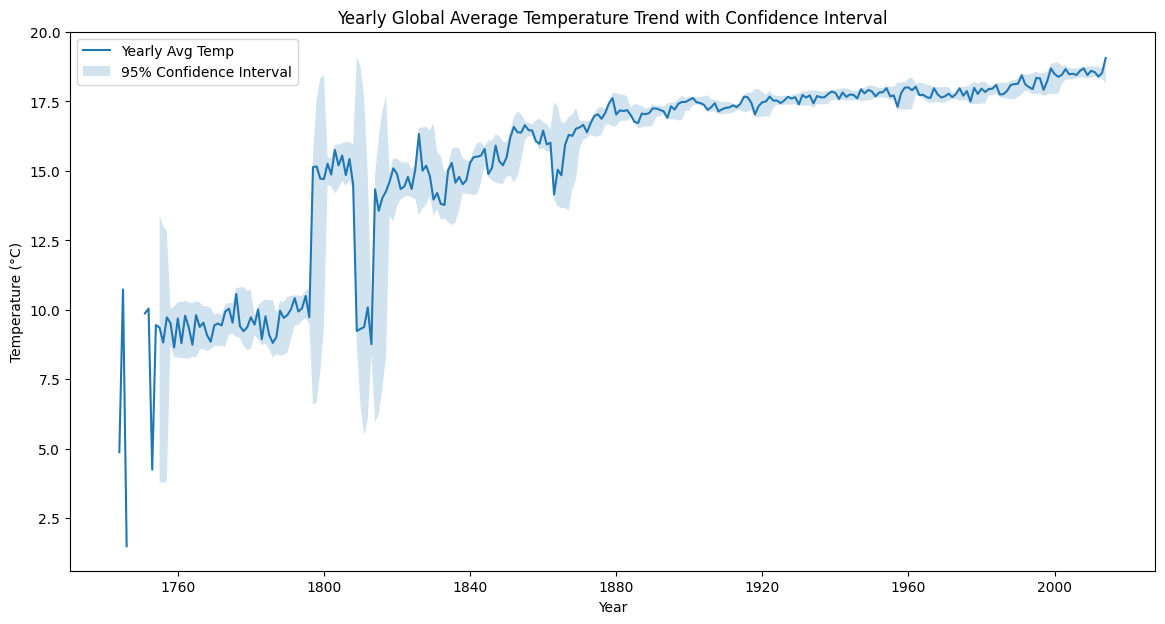

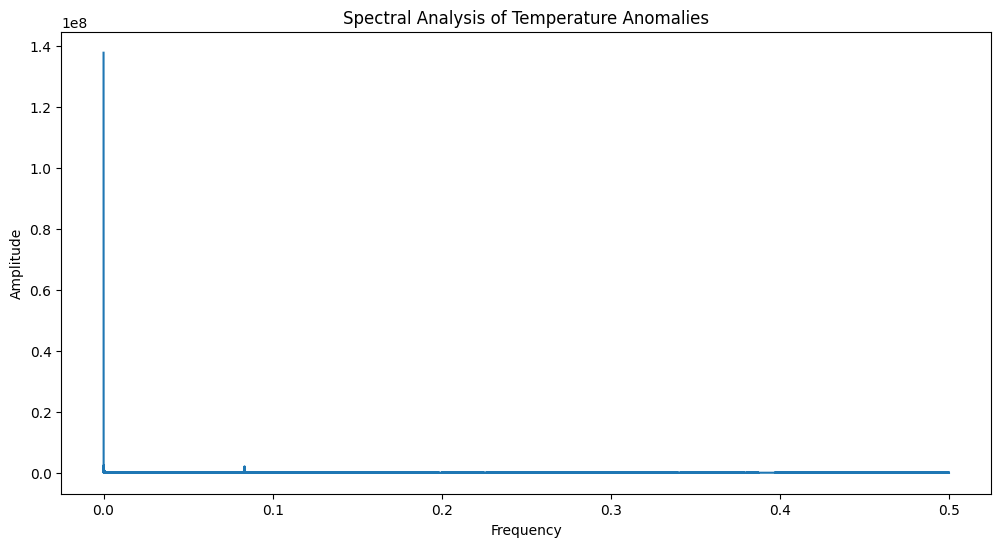

<ipython-input-18-c5b5c3037be3>:78: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df['AverageTemperature'].resample('Y').mean()


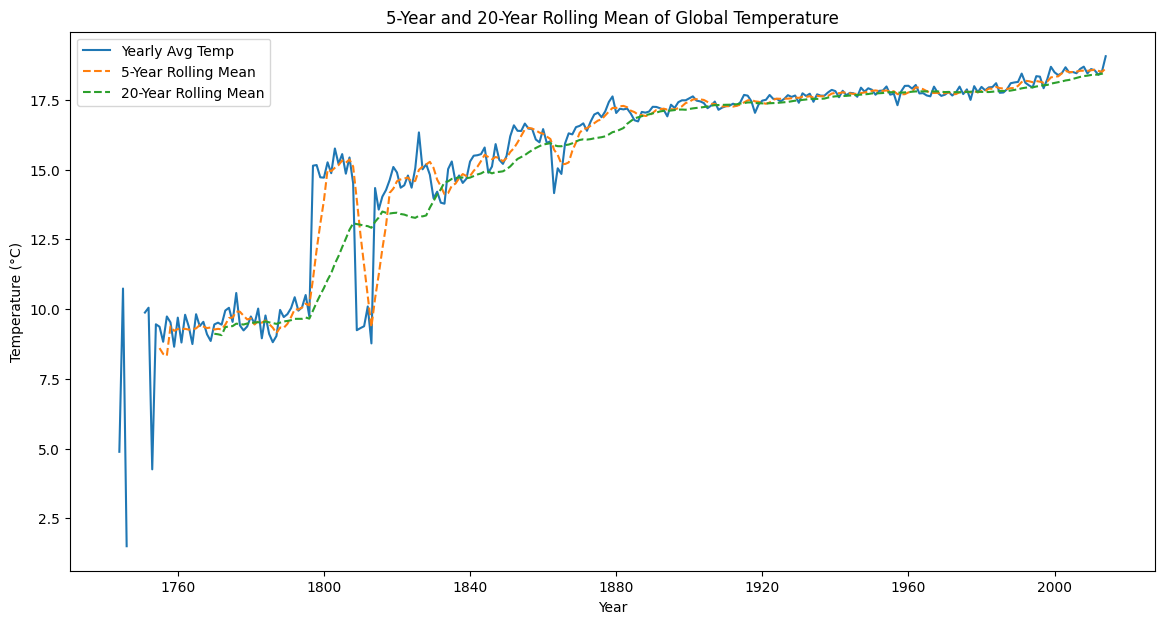

<ipython-input-18-c5b5c3037be3>:90: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df['AverageTemperature'].resample('Y').mean().dropna()
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

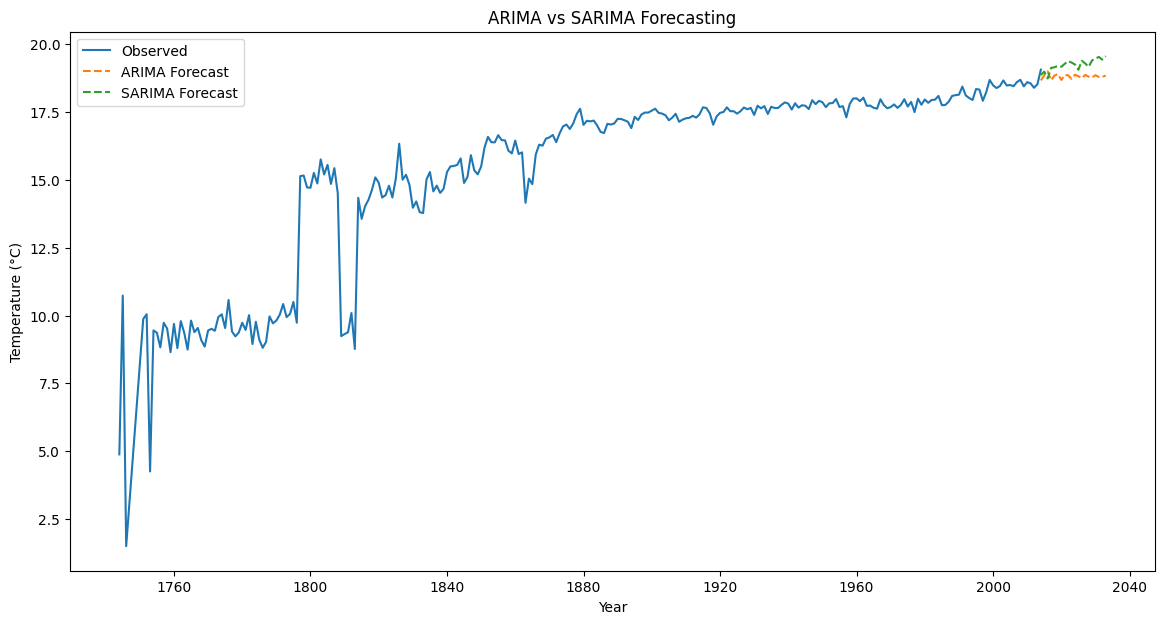

<ipython-input-18-c5b5c3037be3>:111: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df['AverageTemperature'].resample('Y').mean().dropna()


T-Statistic: -8.292362074637888, P-Value: 5.6410708574039264e-15
Significant difference between pre-1950 and post-1950 average temperatures.

=== Documentation ===

        === Final Research Report ===

        Goal:
        Investigate the impact of climate change on global temperature trends using historical data.

        Literature Review:
        Research on the impact of climate change on global temperature trends shows a general consensus among scientists: global temperatures are rising due to human activities, particularly greenhouse gas emissions. Several studies have examined global temperature trends using historical data, providing valuable insights into how climate change is influencing these trends. 

Key Findings:

1. Global warming trends - The Global Climate Change: Vital Signs of the Planet report by NASA (2021) highlights that average global temperatures have increased by about 0.8 degrees Celsius since 1880, with most of the warming occurring in recent decades. Spe

In [ ]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from openai import OpenAI, RateLimitError
from kaggle.api.kaggle_api_extended import KaggleApi
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import linregress, ttest_ind

# Set environment variables and initialize API clients
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

# Base class for agents with OpenAI and Kaggle functionalities
class Agent:
    def __init__(self, name, role):
        self.name = name
        self.role = role
        self.api_client = client
        self.kaggle_api = KaggleApi()
        self.kaggle_api.authenticate()

    def query_openai(self, prompt, retries=5, initial_delay=2):
        for attempt in range(retries):
            try:
                response = self.api_client.chat.completions.create(
                    model="gpt-4",
                    messages=[{"role": "user", "content": prompt}]
                )
                return response.choices[0].message.content
            except RateLimitError:
                if attempt < retries - 1:
                    delay = initial_delay * (2 ** attempt)
                    print(f"Rate limit exceeded. Retrying in {delay} seconds...")
                    time.sleep(delay)
                else:
                    raise

    def retrieve_kaggle_data(self, dataset, file_name):
        print("\n=== Downloading Dataset from Kaggle ===")
        self.kaggle_api.dataset_download_files(dataset, path=".", unzip=True)
        print(f"Downloaded and unzipped dataset: {dataset}.zip")
        return pd.read_csv(file_name)

# Specialized agents for different research tasks
class DataAnalysisAgent(Agent):
    def plot_time_series(self, df):
        df_yearly = df['AverageTemperature'].resample('Y').mean()
        plt.figure(figsize=(14, 7))
        plt.plot(df_yearly.index, df_yearly, label="Yearly Avg Temp")
        plt.fill_between(df_yearly.index,
                         df_yearly.rolling(window=5).mean() - 1.96 * df_yearly.rolling(window=5).std(),
                         df_yearly.rolling(window=5).mean() + 1.96 * df_yearly.rolling(window=5).std(),
                         alpha=0.2, label="95% Confidence Interval")
        plt.title("Yearly Global Average Temperature Trend with Confidence Interval")
        plt.xlabel("Year")
        plt.ylabel("Temperature (°C)")
        plt.legend()
        plt.show()

    def spectral_analysis(self, df):
        temperature_data = df['AverageTemperature'].dropna()
        temperature_fft = np.fft.fft(temperature_data)
        freqs = np.fft.fftfreq(len(temperature_data))

        plt.figure(figsize=(12, 6))
        plt.plot(freqs[:len(freqs)//2], np.abs(temperature_fft[:len(freqs)//2]))
        plt.title("Spectral Analysis of Temperature Anomalies")
        plt.xlabel("Frequency")
        plt.ylabel("Amplitude")
        plt.show()

    def rolling_statistics(self, df):
        df_yearly = df['AverageTemperature'].resample('Y').mean()
        plt.figure(figsize=(14, 7))
        plt.plot(df_yearly.index, df_yearly, label="Yearly Avg Temp")
        plt.plot(df_yearly.index, df_yearly.rolling(window=5).mean(), label="5-Year Rolling Mean", linestyle="--")
        plt.plot(df_yearly.index, df_yearly.rolling(window=20).mean(), label="20-Year Rolling Mean", linestyle="--")
        plt.title("5-Year and 20-Year Rolling Mean of Global Temperature")
        plt.xlabel("Year")
        plt.ylabel("Temperature (°C)")
        plt.legend()
        plt.show()

    def compare_forecasting_models(self, df):
        df_yearly = df['AverageTemperature'].resample('Y').mean().dropna()

        arima_model = ARIMA(df_yearly, order=(5, 1, 0))
        arima_fit = arima_model.fit()
        arima_forecast = arima_fit.forecast(steps=20)

        sarima_model = SARIMAX(df_yearly, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_fit = sarima_model.fit()
        sarima_forecast = sarima_fit.get_forecast(steps=20).predicted_mean

        plt.figure(figsize=(14, 7))
        plt.plot(df_yearly.index, df_yearly, label="Observed")
        plt.plot(pd.date_range(df_yearly.index[-1], periods=20, freq='Y'), arima_forecast, label="ARIMA Forecast", linestyle="--")
        plt.plot(pd.date_range(df_yearly.index[-1], periods=20, freq='Y'), sarima_forecast, label="SARIMA Forecast", linestyle="--")
        plt.title("ARIMA vs SARIMA Forecasting")
        plt.xlabel("Year")
        plt.ylabel("Temperature (°C)")
        plt.legend()
        plt.show()

    def hypothesis_testing(self, df):
        df_yearly = df['AverageTemperature'].resample('Y').mean().dropna()
        pre_1950 = df_yearly[df_yearly.index.year < 1950]
        post_1950 = df_yearly[df_yearly.index.year >= 1950]

        t_stat, p_value = ttest_ind(pre_1950, post_1950)
        print(f"T-Statistic: {t_stat}, P-Value: {p_value}")
        if p_value < 0.05:
            print("Significant difference between pre-1950 and post-1950 average temperatures.")
        else:
            print("No significant difference detected between pre-1950 and post-1950 temperatures.")

    def analyze_and_learn(self, df):
        trend, intercept, r_value, p_value, std_err = linregress(df.index.year, df['AverageTemperature'])
        summary = f"Slope (°C/Year): {trend:.3f}\nIntercept: {intercept:.3f}°C\nR-squared: {r_value**2:.3f}\nP-value: {p_value:.3e}"
        print("Trend Analysis:\n", summary)
        return summary

# Adding the remaining agents as specified, unchanged
class LiteratureReviewAgent(Agent):
    def conduct_review(self, topic):
        prompt = f"Conduct a literature review on {topic}, summarizing key findings, gaps, and challenges."
        return self.query_openai(prompt)

class HypothesisAgent(Agent):
    def generate_hypotheses(self, literature):
        prompt = f"Generate hypotheses based on this literature review: {literature}"
        return self.query_openai(prompt)

class ExperimentationAgent(Agent):
    def design_experiment(self, hypothesis):
        prompt = f"Design an experiment to test this hypothesis: {hypothesis}"
        return self.query_openai(prompt)

#class PredictiveModelAgent(Agent):
    #def forecast_trends(self, df):
        # Forecasting methods already handled within the DataAnalysisAgent

class DocumentationAgent(Agent):
    def compile_report(self, goal, literature, hypotheses, experiment, analysis_summary):
        report = f"""
        === Final Research Report ===

        Goal:
        {goal}

        Literature Review:
        {literature}

        Hypotheses:
        {hypotheses}

        Experiment Design:
        {experiment}

        Data Analysis Summary:
        {analysis_summary}
        """
        print(report)
        return report

# Project Manager to coordinate tasks
class ProjectManagerAgent(Agent):
    def execute_research_workflow(self, goal, kaggle_dataset=None, file_name=None):
        review_agent = LiteratureReviewAgent("Literature Review Agent", "Conducts literature reviews")
        hypothesis_agent = HypothesisAgent("Hypothesis Agent", "Generates hypotheses")
        experiment_agent = ExperimentationAgent("Experiment Agent", "Designs experiments")
        data_agent = DataRetrievalAgent("Data Agent", "Retrieves and preprocesses data")
        analysis_agent = DataAnalysisAgent("Data Analysis Agent", "Performs data analysis")
        model_agent = PredictiveModelAgent("Predictive Model Agent", "Forecasts trends")
        doc_agent = DocumentationAgent("Documentation Agent", "Compiles final report")

        print("\n=== Starting Data Retrieval ===")
        data = data_agent.retrieve_and_preprocess_data(kaggle_dataset, file_name)

        print("\n=== Literature Review ===")
        literature_review = review_agent.conduct_review(goal)

        print("\n=== Hypothesis Generation ===")
        hypotheses = hypothesis_agent.generate_hypotheses(literature_review)

        print("\n=== Experiment Design ===")
        experiment_design = experiment_agent.design_experiment(hypotheses)

        print("\n=== Data Analysis ===")
        analysis_summary = analysis_agent.analyze_and_learn(data)
        analysis_agent.plot_time_series(data)
        analysis_agent.spectral_analysis(data)
        analysis_agent.rolling_statistics(data)
        analysis_agent.compare_forecasting_models(data)
        analysis_agent.hypothesis_testing(data)

        print("\n=== Documentation ===")
        doc_agent.compile_report(goal, literature_review, hypotheses, experiment_design, analysis_summary)

# Execution setup
goal = "Investigate the impact of climate change on global temperature trends using historical data."
kaggle_dataset = "berkeleyearth/climate-change-earth-surface-temperature-data"
file_name = "GlobalLandTemperaturesByCity.csv"

manager = ProjectManagerAgent("Project Manager", "Orchestrates complex research workflows")
manager.execute_research_workflow(goal, kaggle_dataset, file_name)
